<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">
           <a href="https://bokeh.org/">     
           </a>    
       </td>
       <td style="border:none">
           <h1>Uncertainty Spillover</h1>
       </td>
   </tr>
</table>

<div style="float:right;"><h2>Jump in [$\underline y$, $\overline y$]</h2></div>

In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one_100, solve_smooth_unreveal, generate_weight, solve_smooth_100, value_for_match
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["lines.linewidth"] = 2.5
mpl.rcParams['legend.frameon'] = False

In [2]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*μ
ς = 0.1
# damage function
ȳ = 1.7
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
# y grid
numy_bar = 100
y_min = 1e-10
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

In [3]:
# capital parameters
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [4]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

# Jump model of damages
Intensity function:
$$
\mathcal{I}(y) = \begin{cases}
(\frac{1}{\sqrt{2\pi} \varsigma})\exp\left[- \frac{(y - \bar y)^2}{2\varsigma^2}\right], \quad y \leqslant \bar y\\
(\frac{1}{\sqrt{2\pi}\varsigma}), \quad y > \bar y
\end{cases}
$$

HJB
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{\pi^d} &- \delta \phi(y) + \eta \log\tilde e \\
    & +  \frac{d\phi}{dy}\sum_i \pi_i^a\theta_i \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2} \frac{(\eta - 1)}{\delta} \gamma_2 (\tilde e)^2 |\sigma_y|^2\\
& + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y) \tilde e \sum_i \pi_i^a\theta_i + \mathcal{I}(y)\sum_j \pi^d_j \left[\phi_j(y) - \phi(y) \right] \\
&  + \textbf{relative entropy}
\end{aligned}
$$
## Approach one:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) +  \eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2  + \frac{\xi_m}{2} h'h\\
& + [ \frac{d\phi}{dy}    + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)]\cdot \tilde e \sigma_y h +\frac{1}{2}\frac{ (\eta - 1)}{\delta} \gamma_2 (\tilde e)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \frac{d\phi}{dy} \theta_i \tilde e  + \sum_i \pi_i^c \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y) \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i)\\
&  + \mathcal{I}(y)\sum_j\hat\pi_j^d g_j\left[\phi_j(y) - \phi(y) \right]  + \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j + g_j \log g_j]
\end{aligned}
$$
The optimal $g_j$:
$$
g_j^* = \exp\{\frac{1}{\xi_m}\left( \phi(y) - \phi_j(y)\right)\}
$$
Plug back in
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) + \eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2}\frac{(\eta -1)}{\delta}\gamma_2(\tilde e)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \left[\frac{d\phi}{dy}  + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)\right] \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i) \\
&  +  \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j^* ]
\end{aligned}
$$
Intensity altered to be $\iota^*(y) \mathcal{I} (y)$ where:
$$
\iota^*(y)  = \sum_j \hat\pi_j g_j^* 
$$
Distorted probability:
$$
\pi^*_j  = \frac{\exp\left(-\frac{1}{\xi_m} [\phi_j(y) - \phi(y)] \right) \hat\pi_j}{\iota^*(y)}
$$

In [5]:
def simulate_jump(y_grid, solu, ME,  θ_list, y_start=1, T=100, dt=1):
    ems = solu["ems"]
    πᶜ = solu["πc"]
    πᵈ = solu["πd"]
    ι = solu["ι"]
    h = solu["h"]
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πᶜt = np.zeros((periods, len(θ_list)))
    πᵈt = np.zeros((periods, len(πᵈ)))
    ιt = np.zeros(periods)
    ht = np.zeros(periods)
    if ME is not None:
        me_t = np.zeros(periods)
    # interpolate
    get_πᵈ = interpolate.interp1d(y_grid, πᵈ)
    get_πᶜ = interpolate.interp1d(y_grid, πᶜ)
#     y = np.mean(θ_list)*290
    y = y_start
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            πᵈ_list = get_πᵈ(y)
            πᶜ_list = get_πᶜ(y)
            ι_point = np.interp(y, y_grid, ι)
            h_point = np.interp(y, y_grid, h)
            if ME is not None:
                me_point = np.interp(y, y_grid, ME)
                me_t[t] = me_point
            et[t] = ems_point
            πᵈt[t] = πᵈ_list
            πᶜt[t] = πᶜ_list
            ιt[t] = ι_point
            ht[t] = h_point
            yt[t] = y
            dy = ems_point*np.mean(θ_list)*dt
            y = dy + y
    if ME is not None:
        return yt, et, πᵈt, πᶜt, ιt, ht, me_t
    else:
        return yt, et, πᵈt, πᶜt, ιt, ht

In [6]:
def plot_solu(ht, πᵈt, ϕ_list, solu, args):
    ϕ = solu['φ']
    ξa, ξw, ξp, numy_bar, dmg_weight = args
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
    fig.suptitle(r'$\xi_a = {}, \quad  \xi_w =1/{}, \quad \xi_p = 1/{} $'.format(ξa, int(1/ξw), int(1/ξp)))
    ax1.plot(ht)
    ax1.set_ylim(bottom=0, top=0.3)
    ax1.set_xlim(left=0)
    ax1.set_xlabel('years')
    ax1.set_ylabel('h')
    if np.count_nonzero(dmg_weight) > 2:
        ax2.plot(πᵈt[:,-1][πᵈt[:,-1]>0], label="extreme damage")
    ax2.plot(πᵈt[:,1][πᵈt[:,1]>0], label="high damage")
    ax2.plot(πᵈt[:,0][πᵈt[:,0]>0], label="low damage")
    # ax2.plot(πᵈt[:,2], label="extreme")
    ax2.set_ylim(bottom=0, top=1)
    ax2.set_xlim(left=0)
    ax2.legend()
    ax2.set_xlabel('years')
    ax2.set_ylabel('πᵈ')
    # plot 3
    ϕ_bound = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)
    ϕ_bound = -ξp*np.log(ϕ_bound)
    ax3.plot(y_grid[:numy_bar+1], ϕ, label='prior to jump')
    ax3.plot(y_grid[numy_bar:], ϕ_list[0][numy_bar:], linestyle="--", color="black", label="post jump, low damage")
    ax3.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="post jump, certainty equivalent")
    ax3.plot(y_grid[numy_bar:], ϕ_list[1][numy_bar:], linestyle="-.", color="black", label="post jump, high damage")
    if np.count_nonzero(dmg_weight) > 2:
        ax3.plot(y_grid[numy_bar:], ϕ_list[-1][numy_bar:], linestyle=":", color="black", label="post jump, extreme damage")
    ax3.vlines(x=2, ymin=-11, ymax=5, linestyle="dashed", color="black")
    # ax3.xlim(0,4)
    # ax3.ylim(-0.02, 0.05)
    ax3.set_ylabel('$\phi$')
    ax3.set_xlabel('y')
    ax3.set_xlim(left=0)
    ax3.legend()
    # ax3.set_title(r'$\xi_a = 1,000, \quad  \xi_w =1/400, \quad \xi_p = 1/400 \times 5 $')
    # plt.savefig("phi_x1.pdf", facecolor="w", edgecolor='w', bbox_inches="tight") 

In [7]:
y_lower = 1.7
y_bar = 2
y_min = 0
y_max = 4
hy = 0.02
y_grid = np.arange(y_min, y_max+hy, hy)
jump_interval = np.arange(y_lower, y_bar, hy)
pre_jump = np.arange(y_min, 1.7+hy, hy)

In [8]:
pre_jump = np.arange(y_min, 2+hy, hy)
jump_idx = len(pre_jump)-1
y_grid[jump_idx], np.arange(y_min, 2+hy, hy)

(2.0,
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
        1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
        1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
        1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
        1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
        1.98, 2.  ]))

In [28]:
ξa = 1/10_000*100
ξw = 1000*100
ξp = 1/20*100
dmg_weight = np.array([1/3, 1/3, 1/3])

pre_jump = np.arange(y_min, 2+hy, hy)
numy_bar = len(pre_jump)-1
args = (δ, η, θ_list, γ1, γ2, γ3_list, 2, dmg_weight, ς, ξp, ξa, ξw, σy)
ϕ_list, π_list = value_for_match(y_grid, numy_bar, args, report_π=True)

episode: 10000,	 ode error: 0.00044409073248848074,	 ft error: 0.0001501373789647431
episode: 5038,	 ode error: 0.00031678354971511474,	 ft error: 9.998391744166687e-09
episode: 5389,	 ode error: 0.0010988225461033745,	 ft error: 9.99224999039446e-09


In [29]:
pre_jump

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  ])

In [30]:
ȳ

1.7

In [31]:
r1 = -54.16692119
r1

-54.16692119

In [32]:
y_grid[shortest_idx:short_idx+1]

array([1.7 , 1.72, 1.74, 1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 ,
       1.92, 1.94, 1.96, 1.98, 2.  ])

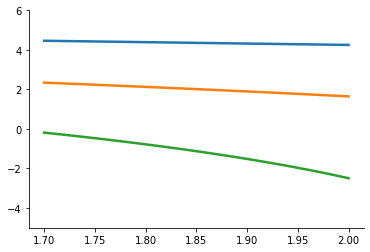

In [33]:
plt.plot(y_grid[shortest_idx:short_idx+1], ϕ_list.T[shortest_idx:short_idx+1])
plt.ylim(-5,6)
plt.show()

In [34]:
r0_list, time_interval_list = ([-4.382975767906238, -1.0957439419765596], [0.25, 1])
r0_list, time_interval_list

([-4.382975767906238, -1.0957439419765596], [0.25, 1])

In [35]:
y_short = np.arange(y_min, 2 + hy, hy)
short_idx = len(y_short) -1
y_grid[:short_idx+1]

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  ])

In [36]:
y_shortest = np.arange(y_min, y_lower, hy)
shortest_idx = len(y_shortest)
y_grid[shortest_idx],y_shortest

(1.7,
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
        1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
        1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
        1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68]))

In [37]:
weighted = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)

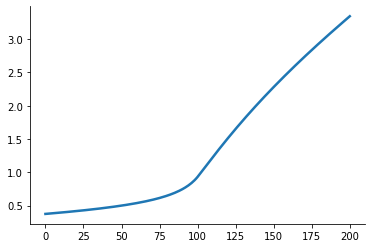

In [38]:
plt.plot(weighted)

## Step I:

for $m = 1,2,3$, and for $\tilde y  = 1.7, 1.72, 1.74, \dots, 1.98$ solve HJB (1) on $y \in [0,4]$:

$$
\begin{aligned}
0 = \max_{\tilde e}\min_{\omega_i^c: \sum_i^L \omega_i^c = 1} &- \delta \tilde \phi_m(y; \tilde y) + \eta \log\tilde e\\
\\
&+ \frac{1}{2} \frac{d^2 \tilde \phi_m}{dy^2}(y; \tilde y) \cdot (\tilde e)^2 |\sigma_y|^2 + \frac{1}{2}\frac{(\eta -1)}{\delta}\left(\gamma_2 + \gamma_3^m\mathbb{I}\{y > \tilde y\}\right)(\tilde e)^2 |\sigma_y|^2\\
\\
    & + \sum_i \omega_i^c \left[\frac{d\tilde \phi_m}{dy}(y; \tilde y)  + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y + \gamma_3^m (y - \tilde y ) \mathbb{I}\{y > \tilde y\})\right] \tilde e \theta_i\\
   \\
   &+ \xi_a \sum_i \omega^c_i(\log \omega^c_i - \log \pi^c_i) \\
\end{aligned}\tag{1}
$$

And get $\{\tilde \phi_m(y;\tilde y)\}_{m=1,2,3; \tilde y = 1.7, 1.72, \dots, 1.98 }$ and let 

$$
\phi_m(\tilde y) = \tilde \phi_m(\tilde y ; \tilde y)
$$

To get $\phi_m(y)$'s value on $[1.7, 2)$ for the next step.


## step II:

Given the $\phi_m(y)$ on $[1.7, 2)$ in step I, solve HJB (2) on $y \in [0,2)$:

$$
\begin{aligned}
0 = \max_{\tilde e}\min_{\omega_i^c: \sum_i^L \omega_i^c = 1} &- \delta \phi(y) + \eta \log\tilde e\\
\\
&+ \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2}\frac{(\eta -1)}{\delta}\gamma_2(\tilde e)^2 |\sigma_y|^2\\
\\
& + \sum_i \omega_i^c \left[\frac{d\phi}{dy}  + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)\right] \tilde e \theta_i + \xi_a \sum_i \omega^c_i(\log \omega^c_i - \log \hat\pi^c_i) \\
\\
 &  -   \xi_p \mathcal{I}(y)  \cfrac{ \sum_{m=1}^M \pi_m^p \exp\left( - \frac{1}{\xi_p} \phi_m\right) - \exp\left( -\frac{1}{\xi_p} \phi \right)}{\exp\left( - \frac{1}{\xi_p} \phi\right)}
\end{aligned}\tag{2}
$$

In [39]:
# solve ϕ
ξp=5
tol=6e-5
max_iter= 5000
ϵ = 0.25

solu_list = []
for i in range(len(r0_list)):
    
    intensity = r0_list[i]*(np.exp(r1/2*(y_grid[:short_idx+1]- y_lower)**2)-1)*(y_grid[:short_idx+1]>=y_lower)
    y_grid_cap = y_grid[:short_idx+1]
    dΛ = γ1 + γ2*y_grid_cap
    ddΛ = γ2
    ems = η
    ems_old = ems

    episode = 0
    lhs_error = 1
    πᵈo = dmg_weight
    πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)
    ϕ = np.average(ϕ_list, axis=0, weights=dmg_weight)[:short_idx+1]

    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, hy, "up")
        dϕdyy = derivative_1d(ϕ, 2, hy, "up")
        # update control
        temp = dϕdy + (η-1)/δ*dΛ 
        weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πᶜ = πᶜo*np.exp(weight)
        πᶜ[πᶜ <= 1e-15] = 1e-15
        πᶜ = πᶜ/np.sum(πᶜ, axis=0)
        # update control
        a = (dϕdyy  - 1/ξw*temp**2 + (η-1)/δ*ddΛ)*σy**2
        b = (θ_list@πᶜ)*temp
        c = η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*0.5 + ems_old*0.5
        #     g_list = np.array([np.exp(1/ξp*(ϕ - ϕ_list[i][:numy_bar+1])) for i in range(len(γ3_list))])
        # coefficients
        A = -δ*np.ones(y_grid_cap.shape)
        By = (θ_list@πᶜ)*ems
        Cyy = ems**2*σy**2/2
        D = η*np.log(ems) + θ_list@πᶜ*(η-1)/δ*dΛ*ems\
        + ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
        - 1/(2*ξw)*temp**2*ems**2*σy**2\
        + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2\
        - ξp*intensity*(weighted[:short_idx+1] - np.exp(-1/ξp*ϕ))/np.exp(-1/ξp*ϕ)
        # solver
        ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (False, weighted[short_idx]))
        rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
        ems_old = ems
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    # dϕdy = derivative_1d(ϕ, 1, dy, "up")
    # dϕdyy = derivative_1d(ϕ, 2, dy, "up")
    temp = dϕdy + (η-1)/δ*dΛ 
    h =  - temp*ems*σy/ξw
    g_list = np.array([np.exp(1/ξp*(ϕ - ϕ_list[i][:short_idx+1])) for i in range(len(γ3_list))])
    
    πd = np.array([πdo[i]*g_list[i] for i in range(len(γ3_list))])/(πdo@g_list)
    # ι, πᵈ = get_ι(πᵈo, g_list)
    # penalty = ξp*get_intensity(y_grid_cap, ς)*(πᵈo@(1 - g_list))
    solution = dict(ϕ=ϕ, ems=ems, πd=πd, πc=πᶜ)
    solu_list.append(solution)

episode: 1,	 ode error: 3.3682019135860934,	 ft error: 3.3802896836022875
episode: 2,	 ode error: 0.4989140586431031,	 ft error: 0.4979618199757896
episode: 3,	 ode error: 0.2794424321789707,	 ft error: 0.2783930369198089
episode: 4,	 ode error: 0.1946961679839546,	 ft error: 0.1933930600435101
episode: 5,	 ode error: 0.1497105382942453,	 ft error: 0.14899425794601218
episode: 6,	 ode error: 0.12267622516229347,	 ft error: 0.12068407209658005
episode: 7,	 ode error: 0.10293789590525737,	 ft error: 0.10276278719661391
episode: 8,	 ode error: 0.09213668484243182,	 ft error: 0.09095079820888508
episode: 9,	 ode error: 0.08229620329279175,	 ft error: 0.08004342072759929
episode: 10,	 ode error: 0.0733856355333941,	 ft error: 0.07038552116831909
episode: 11,	 ode error: 0.06566195846971347,	 ft error: 0.06586070751128936
episode: 12,	 ode error: 0.06254262335045928,	 ft error: 0.06227754065709412
episode: 13,	 ode error: 0.05943864448315754,	 ft error: 0.05849417243432953
episode: 14,	 ode 

episode: 187,	 ode error: 0.00985621464151494,	 ft error: 0.010238436561941455
episode: 188,	 ode error: 0.009819483350269442,	 ft error: 0.010171073695097732
episode: 189,	 ode error: 0.00977910527069406,	 ft error: 0.010125550778179004
episode: 190,	 ode error: 0.009735449939724174,	 ft error: 0.010002811049325544
episode: 191,	 ode error: 0.00968733089749245,	 ft error: 0.009966813612351189
episode: 192,	 ode error: 0.009635454499676295,	 ft error: 0.010004231374276529
episode: 193,	 ode error: 0.009584007557826915,	 ft error: 0.009949373492592173
episode: 194,	 ode error: 0.009552692631491541,	 ft error: 0.009913651698218118
episode: 195,	 ode error: 0.009518358231660293,	 ft error: 0.00978899648966447
episode: 196,	 ode error: 0.009479838494445912,	 ft error: 0.00973539817183422
episode: 197,	 ode error: 0.009437836459996692,	 ft error: 0.009763210058610028
episode: 198,	 ode error: 0.00939342183372286,	 ft error: 0.009718679785960305
episode: 199,	 ode error: 0.009345562705195008

episode: 364,	 ode error: 0.005052960642744991,	 ft error: 0.005170781794896939
episode: 365,	 ode error: 0.005037365015183655,	 ft error: 0.005131600233209355
episode: 366,	 ode error: 0.005021341040214115,	 ft error: 0.005115532506611231
episode: 367,	 ode error: 0.005004262583270247,	 ft error: 0.005097534867651632
episode: 368,	 ode error: 0.0049862508101681385,	 ft error: 0.005079874411924479
episode: 369,	 ode error: 0.004970709295536377,	 ft error: 0.005085351567208463
episode: 370,	 ode error: 0.0049552383367175296,	 ft error: 0.0050666079497379
episode: 371,	 ode error: 0.00493888365171713,	 ft error: 0.005024761401934086
episode: 372,	 ode error: 0.004922105946048777,	 ft error: 0.005013166644843636
episode: 373,	 ode error: 0.004904299776541873,	 ft error: 0.004995221256592686
episode: 374,	 ode error: 0.004889713251040616,	 ft error: 0.004976644603464919
episode: 375,	 ode error: 0.004874954281417827,	 ft error: 0.004957013150075795
episode: 376,	 ode error: 0.0048592492854

episode: 547,	 ode error: 0.002742778589741507,	 ft error: 0.002678575109904102
episode: 548,	 ode error: 0.0027214671177675648,	 ft error: 0.002655014757845464
episode: 549,	 ode error: 0.002699785421899595,	 ft error: 0.002630946633285447
episode: 550,	 ode error: 0.0026775817172160488,	 ft error: 0.002669466454843672
episode: 551,	 ode error: 0.002660445130569608,	 ft error: 0.0026490976506714503
episode: 552,	 ode error: 0.0026406010203375158,	 ft error: 0.0025781027307729687
episode: 553,	 ode error: 0.0026151245458048145,	 ft error: 0.0025702784489638475
episode: 554,	 ode error: 0.002592114405343543,	 ft error: 0.0025442544076952345
episode: 555,	 ode error: 0.002568568390171236,	 ft error: 0.002519087731258196
episode: 556,	 ode error: 0.00254472383351248,	 ft error: 0.0024934085975054643
episode: 557,	 ode error: 0.0025205725359548764,	 ft error: 0.0024673479626926564
episode: 558,	 ode error: 0.0024961271476880847,	 ft error: 0.0024408924325705073
episode: 559,	 ode error: 0.

episode: 655,	 ode error: 0.0017547502696538958,	 ft error: 0.0003684646506876277
episode: 656,	 ode error: 0.0017555425053963625,	 ft error: 0.00035245685089435597
episode: 657,	 ode error: 0.0017572312547595448,	 ft error: 0.0003354823542665031
episode: 658,	 ode error: 0.0017594699323832744,	 ft error: 0.00038067455711043863
episode: 659,	 ode error: 0.0017574562016453021,	 ft error: 0.0003729437927049162
episode: 660,	 ode error: 0.001755142131930315,	 ft error: 0.0003495434268498965
episode: 661,	 ode error: 0.0017560728912443604,	 ft error: 0.00031801182220903
episode: 662,	 ode error: 0.0017559257388918628,	 ft error: 0.0003012878135209007
episode: 663,	 ode error: 0.001756863662728883,	 ft error: 0.00028666937334165254
episode: 664,	 ode error: 0.0017582690445911014,	 ft error: 0.00034705508674637287
episode: 665,	 ode error: 0.0017560305620853145,	 ft error: 0.00032092354253521194
episode: 666,	 ode error: 0.001753515192546816,	 ft error: 0.0003257680856496581
episode: 667,	 o

episode: 110,	 ode error: 0.01523013619951788,	 ft error: 0.01586222983054064
episode: 111,	 ode error: 0.015117063485296504,	 ft error: 0.015811597911389086
episode: 112,	 ode error: 0.014996196091497917,	 ft error: 0.01558097735857622
episode: 113,	 ode error: 0.01491520647090537,	 ft error: 0.015492537866588663
episode: 114,	 ode error: 0.01485796925376974,	 ft error: 0.015550324232952661
episode: 115,	 ode error: 0.01479490937075597,	 ft error: 0.01542460721189265
episode: 116,	 ode error: 0.014724468691382768,	 ft error: 0.015332850910768414
episode: 117,	 ode error: 0.01464713525701726,	 ft error: 0.015058849911275374
episode: 118,	 ode error: 0.014561325476262363,	 ft error: 0.014987072622229647
episode: 119,	 ode error: 0.014467862850808845,	 ft error: 0.015070343249687923
episode: 120,	 ode error: 0.014368216044796683,	 ft error: 0.014985374409771879
episode: 121,	 ode error: 0.01426112079748005,	 ft error: 0.014933011843583088
episode: 122,	 ode error: 0.014177397051047376,	 

episode: 306,	 ode error: 0.006508173466825043,	 ft error: 0.006682269495982496
episode: 307,	 ode error: 0.006485739239885706,	 ft error: 0.006657947011122545
episode: 308,	 ode error: 0.006465222844852743,	 ft error: 0.006651778232340533
episode: 309,	 ode error: 0.0064440355970656615,	 ft error: 0.0066211425463276186
episode: 310,	 ode error: 0.006421353282638313,	 ft error: 0.006598726968094937
episode: 311,	 ode error: 0.006397326007363417,	 ft error: 0.006580070257149018
episode: 312,	 ode error: 0.006371992984767191,	 ft error: 0.006541901456806443
episode: 313,	 ode error: 0.0063517983579694515,	 ft error: 0.006517901368603418
episode: 314,	 ode error: 0.006331451139357749,	 ft error: 0.006508871193018351
episode: 315,	 ode error: 0.0063104690449558645,	 ft error: 0.006479253348929959
episode: 316,	 ode error: 0.006288041218545239,	 ft error: 0.0064590060502514035
episode: 317,	 ode error: 0.006264317336656382,	 ft error: 0.006440156333120228
episode: 318,	 ode error: 0.0062406

episode: 487,	 ode error: 0.0036384336167056275,	 ft error: 0.0036592856741322066
episode: 488,	 ode error: 0.0036282096518016893,	 ft error: 0.0036452605768850788
episode: 489,	 ode error: 0.003617493032524996,	 ft error: 0.003630874311596699
episode: 490,	 ode error: 0.0036062809229083642,	 ft error: 0.0036180984999916177
episode: 491,	 ode error: 0.0035953161903576614,	 ft error: 0.0036048735715432656
episode: 492,	 ode error: 0.0035852337198776507,	 ft error: 0.003591184946980519
episode: 493,	 ode error: 0.003574666006588026,	 ft error: 0.0035771975991494287
episode: 494,	 ode error: 0.0035634458416500814,	 ft error: 0.003631667074703415
episode: 495,	 ode error: 0.0035524297307153035,	 ft error: 0.0036201822891293034
episode: 496,	 ode error: 0.003542153783836377,	 ft error: 0.0035502043464035182
episode: 497,	 ode error: 0.003531574894965958,	 ft error: 0.0035529131333085218
episode: 498,	 ode error: 0.0035204441807493297,	 ft error: 0.0035398610909425088
episode: 499,	 ode erro

episode: 697,	 ode error: 0.001379877133496736,	 ft error: 0.00020802054241286783
episode: 698,	 ode error: 0.0013803748063914156,	 ft error: 0.00019637858638432704
episode: 699,	 ode error: 0.0013812804386437796,	 ft error: 0.00018387643918060803
episode: 700,	 ode error: 0.0013821865161856087,	 ft error: 0.00028813035876207316
episode: 701,	 ode error: 0.0013808802040904608,	 ft error: 0.0002280484442636066
episode: 702,	 ode error: 0.0013797576633163139,	 ft error: 0.00017806452367641334
episode: 703,	 ode error: 0.0013803945436796292,	 ft error: 0.0001799420606189983
episode: 704,	 ode error: 0.0013804617868271793,	 ft error: 0.00016748977470015802
episode: 705,	 ode error: 0.001381008977423867,	 ft error: 0.00015682437978270514
episode: 706,	 ode error: 0.0013819669014617161,	 ft error: 0.00014528080378539698
episode: 707,	 ode error: 0.0013829225019719102,	 ft error: 0.00029116446845800503
episode: 708,	 ode error: 0.0013816299882186828,	 ft error: 0.00021735803796718578
episode:

episode: 888,	 ode error: 0.0013829633736298086,	 ft error: 6.717938912648158e-05
episode: 889,	 ode error: 0.0013829287657972991,	 ft error: 8.313092413603229e-05
episode: 890,	 ode error: 0.0013833329377920325,	 ft error: 8.76725814302759e-05
episode: 891,	 ode error: 0.0013841238700284947,	 ft error: 9.550420857085129e-05
episode: 892,	 ode error: 0.0013848921140104317,	 ft error: 0.00028809133368778994
episode: 893,	 ode error: 0.001383515970323143,	 ft error: 0.00021509058107338497
episode: 894,	 ode error: 0.0013823255100899531,	 ft error: 0.00017852938833895493
episode: 895,	 ode error: 0.0013828802742716015,	 ft error: 6.718350408485563e-05
episode: 896,	 ode error: 0.0013829085273794478,	 ft error: 8.359236678501247e-05
episode: 897,	 ode error: 0.001383379410789691,	 ft error: 8.83209493589554e-05
episode: 898,	 ode error: 0.0013842395662105045,	 ft error: 9.63627481340712e-05
episode: 899,	 ode error: 0.001385075301737905,	 ft error: 0.00029069706767637093
episode: 900,	 ode

episode: 1061,	 ode error: 0.001383058698812549,	 ft error: 8.325919142571081e-05
episode: 1062,	 ode error: 0.001383466550713891,	 ft error: 8.78106231179121e-05
episode: 1063,	 ode error: 0.0013842617331778634,	 ft error: 9.56542693573148e-05
episode: 1064,	 ode error: 0.0013850340832882654,	 ft error: 0.00028848854318663797
episode: 1065,	 ode error: 0.0013836569376280486,	 ft error: 0.00021538720945613044
episode: 1066,	 ode error: 0.0013824658815373841,	 ft error: 0.00017881205315917192
episode: 1067,	 ode error: 0.0013830247759798048,	 ft error: 6.729326694920879e-05
episode: 1068,	 ode error: 0.0013830562771065258,	 ft error: 8.372540783208038e-05
episode: 1069,	 ode error: 0.0013835310246533214,	 ft error: 8.846567347919887e-05
episode: 1070,	 ode error: 0.0013843956336428362,	 ft error: 9.652141680760451e-05
episode: 1071,	 ode error: 0.0013852356426515763,	 ft error: 0.0002911310801778644
episode: 1072,	 ode error: 0.0013838896847497423,	 ft error: 0.00021735940920830643
epis

episode: 1243,	 ode error: 0.0013849977641047853,	 ft error: 0.00029045704799623984
episode: 1244,	 ode error: 0.0013836534268081568,	 ft error: 0.0002168565343501072
episode: 1245,	 ode error: 0.001382495037868664,	 ft error: 0.00017968748803864898
episode: 1246,	 ode error: 0.001383104123859183,	 ft error: 6.726913478538599e-05
episode: 1247,	 ode error: 0.00138317769262912,	 ft error: 8.40064809386476e-05
episode: 1248,	 ode error: 0.0013836958874033425,	 ft error: 8.886602419599932e-05
episode: 1249,	 ode error: 0.0013846044954637163,	 ft error: 9.70556079749052e-05
episode: 1250,	 ode error: 0.0013854865403311115,	 ft error: 0.0002927540146739904
episode: 1251,	 ode error: 0.0013841593860491955,	 ft error: 0.0002185706725406078
episode: 1252,	 ode error: 0.0013830183517334754,	 ft error: 0.00018091482027626782
episode: 1253,	 ode error: 0.0013836673842166705,	 ft error: 6.737286547320309e-05
episode: 1254,	 ode error: 0.001383771740941335,	 ft error: 8.449992367665082e-05
episode:

episode: 1447,	 ode error: 0.001385738775901986,	 ft error: 8.566978125501556e-05
episode: 1448,	 ode error: 0.0013863253049329755,	 ft error: 9.102681926820289e-05
episode: 1449,	 ode error: 0.001386867250907385,	 ft error: 0.00027482574818771255
episode: 1450,	 ode error: 0.0013854206427143384,	 ft error: 0.00020516914775381423
episode: 1451,	 ode error: 0.0013841383292319542,	 ft error: 0.0001731458302098865
episode: 1452,	 ode error: 0.0013844684227890466,	 ft error: 6.754286116650299e-05
episode: 1453,	 ode error: 0.0013843046877789478,	 ft error: 8.240195637809755e-05
episode: 1454,	 ode error: 0.001384560963879504,	 ft error: 8.649890880341182e-05
episode: 1455,	 ode error: 0.0013851892880873268,	 ft error: 9.37476658602332e-05
episode: 1456,	 ode error: 0.0013857924242645578,	 ft error: 0.00028053127866489724
episode: 1457,	 ode error: 0.0013843402967643678,	 ft error: 0.0002094441286537574
episode: 1458,	 ode error: 0.0013830654915303955,	 ft error: 0.00017551950027949736
epis

episode: 1550,	 ode error: 0.0013841872566239255,	 ft error: 8.471350050953674e-05
episode: 1551,	 ode error: 0.0013847396738558768,	 ft error: 8.978719011665248e-05
episode: 1552,	 ode error: 0.0013856860281248398,	 ft error: 9.823410200637817e-05
episode: 1553,	 ode error: 0.0013866046665333628,	 ft error: 0.00029568703249127637
episode: 1554,	 ode error: 0.0013852727820934038,	 ft error: 0.00022075930350906603
episode: 1555,	 ode error: 0.0013841283956693498,	 ft error: 0.00018256545144534897
episode: 1556,	 ode error: 0.001384804715139451,	 ft error: 6.754827875576908e-05
episode: 1557,	 ode error: 0.0013849256723344402,	 ft error: 8.519742962787014e-05
episode: 1558,	 ode error: 0.001385499336071433,	 ft error: 9.041606539161862e-05
episode: 1559,	 ode error: 0.0013864692605678464,	 ft error: 9.903783884634976e-05
episode: 1560,	 ode error: 0.0013874106528106306,	 ft error: 0.00029767268738400965
episode: 1561,	 ode error: 0.0013860735417029618,	 ft error: 0.0002222410153049914
ep

episode: 1739,	 ode error: 0.0013878928734812057,	 ft error: 0.0002988379667812069
episode: 1740,	 ode error: 0.0013865525637753243,	 ft error: 0.0002231105626051555
episode: 1741,	 ode error: 0.0013854011574269895,	 ft error: 0.00018434586472682035
episode: 1742,	 ode error: 0.0013861032670949291,	 ft error: 6.773931377179743e-05
episode: 1743,	 ode error: 0.001386238526845586,	 ft error: 8.595154348478573e-05
episode: 1744,	 ode error: 0.001386832145003361,	 ft error: 9.139122114842912e-05
episode: 1745,	 ode error: 0.001387380703323969,	 ft error: 0.0002758327606315891
episode: 1746,	 ode error: 0.0013859269244431843,	 ft error: 0.00020592051187029448
episode: 1747,	 ode error: 0.001384637970368023,	 ft error: 0.00017368548306828657
episode: 1748,	 ode error: 0.001384971768659024,	 ft error: 6.758988886867989e-05
episode: 1749,	 ode error: 0.001384808251960086,	 ft error: 8.262748172604972e-05
episode: 1750,	 ode error: 0.0013850666138188958,	 ft error: 8.679536598199533e-05
episode

episode: 1839,	 ode error: 0.0013837803462801446,	 ft error: 8.45145746706244e-05
episode: 1840,	 ode error: 0.0013843328721075548,	 ft error: 8.953117817678269e-05
episode: 1841,	 ode error: 0.0013852778218935782,	 ft error: 9.790803603637599e-05
episode: 1842,	 ode error: 0.0013861948009915026,	 ft error: 0.0002949170186474781
episode: 1843,	 ode error: 0.0013848717298099722,	 ft error: 0.00022018475450580333
episode: 1844,	 ode error: 0.0013837353155206275,	 ft error: 0.0001821181649510617
episode: 1845,	 ode error: 0.0013844109842855792,	 ft error: 6.749575870901303e-05
episode: 1846,	 ode error: 0.0013845336962451868,	 ft error: 8.500279003076372e-05
episode: 1847,	 ode error: 0.0013851072669950476,	 ft error: 9.016573736264633e-05
episode: 1848,	 ode error: 0.0013860756247212822,	 ft error: 9.871906078107173e-05
episode: 1849,	 ode error: 0.0013870152032743471,	 ft error: 0.00029692205782927417
episode: 1850,	 ode error: 0.0013856864960810691,	 ft error: 0.0002216809293458244
epi

episode: 2031,	 ode error: 0.0013856223426094091,	 ft error: 6.766923763357191e-05
episode: 2032,	 ode error: 0.0013857524944612815,	 ft error: 8.567530268877022e-05
episode: 2033,	 ode error: 0.0013863389546993898,	 ft error: 9.103404584465125e-05
episode: 2034,	 ode error: 0.0013868808346564065,	 ft error: 0.00027484648654341193
episode: 2035,	 ode error: 0.0013854338899512222,	 ft error: 0.00020518462224594636
episode: 2036,	 ode error: 0.001384151261757477,	 ft error: 0.00017315640128412468
episode: 2037,	 ode error: 0.0013844812598104786,	 ft error: 6.754331132663438e-05
episode: 2038,	 ode error: 0.0013843173659951122,	 ft error: 8.240612245713486e-05
episode: 2039,	 ode error: 0.0013845735297635595,	 ft error: 8.650452051695012e-05
episode: 2040,	 ode error: 0.001385201778260528,	 ft error: 9.37549858281983e-05
episode: 2041,	 ode error: 0.0013858048454786914,	 ft error: 0.00028055001171045646
episode: 2042,	 ode error: 0.0013843523992742093,	 ft error: 0.00020945810730577108
ep

episode: 2227,	 ode error: 0.0013855707832054129,	 ft error: 0.00028564192704494396
episode: 2228,	 ode error: 0.0013841428965659444,	 ft error: 0.00021326210994332406
episode: 2229,	 ode error: 0.00138289931211686,	 ft error: 0.00017754051984120167
episode: 2230,	 ode error: 0.0013833785113944244,	 ft error: 6.725602624491067e-05
episode: 2231,	 ode error: 0.0013833398312632916,	 ft error: 8.32881966212895e-05
episode: 2232,	 ode error: 0.0013837412269706376,	 ft error: 8.786165838547966e-05
episode: 2233,	 ode error: 0.0013845304780268422,	 ft error: 9.572988387640535e-05
episode: 2234,	 ode error: 0.0013852970518234628,	 ft error: 0.00028874508894993767
episode: 2235,	 ode error: 0.0013839109960022272,	 ft error: 0.00021557869470845148
episode: 2236,	 ode error: 0.0013827113701274443,	 ft error: 0.000178903329246749
episode: 2237,	 ode error: 0.0013832641126954523,	 ft error: 6.725586107081405e-05
episode: 2238,	 ode error: 0.001383288646209034,	 ft error: 8.373977046782777e-05
epis

episode: 2337,	 ode error: 0.0013863057708200094,	 ft error: 0.0002814725067223911
episode: 2338,	 ode error: 0.0013848441494500666,	 ft error: 0.00021014643292982527
episode: 2339,	 ode error: 0.0013835605978504417,	 ft error: 0.0001760509907200447
episode: 2340,	 ode error: 0.0013839602705559562,	 ft error: 6.742542012538877e-05
episode: 2341,	 ode error: 0.0013838519649859576,	 ft error: 8.294618309356849e-05
episode: 2342,	 ode error: 0.001384177109668018,	 ft error: 8.730223556452366e-05
episode: 2343,	 ode error: 0.0013848852181945967,	 ft error: 9.492977972813677e-05
episode: 2344,	 ode error: 0.001385570884020207,	 ft error: 0.0002856421158796696
episode: 2345,	 ode error: 0.0013841429952762135,	 ft error: 0.00021326225084550288
episode: 2346,	 ode error: 0.0013828994089240196,	 ft error: 0.00017754063108221807
episode: 2347,	 ode error: 0.001383378608422206,	 ft error: 6.725604163793086e-05
episode: 2348,	 ode error: 0.0013833399279305839,	 ft error: 8.328824533321288e-05
epis

episode: 2445,	 ode error: 0.001386239390645097,	 ft error: 8.595183727333477e-05
episode: 2446,	 ode error: 0.0013868329991882436,	 ft error: 9.139162838911474e-05
episode: 2447,	 ode error: 0.0013873815484113303,	 ft error: 0.0002758339051140979
episode: 2448,	 ode error: 0.0013859277455149505,	 ft error: 0.0002059213656779857
episode: 2449,	 ode error: 0.0013846387687942233,	 ft error: 0.0001736860211938307
episode: 2450,	 ode error: 0.0013849725563887944,	 ft error: 6.758984482568842e-05
episode: 2451,	 ode error: 0.00138480902535984,	 ft error: 8.262768542577348e-05
episode: 2452,	 ode error: 0.0013850673758639964,	 ft error: 8.679566489466772e-05
episode: 2453,	 ode error: 0.0013856992190911521,	 ft error: 9.412872817637918e-05
episode: 2454,	 ode error: 0.0013863058236643008,	 ft error: 0.00028147259530864055
episode: 2455,	 ode error: 0.0013848442010656742,	 ft error: 0.00021014649902983962
episode: 2456,	 ode error: 0.0013835606483332888,	 ft error: 0.0001760510405968141
episo

episode: 2549,	 ode error: 0.00138510758891143,	 ft error: 9.016603575018323e-05
episode: 2550,	 ode error: 0.0013860759519369603,	 ft error: 9.871944517825249e-05
episode: 2551,	 ode error: 0.0013870155361993403,	 ft error: 0.0002969228316693773
episode: 2552,	 ode error: 0.0013856868236181083,	 ft error: 0.000221681506521465
episode: 2553,	 ode error: 0.0013845457142277959,	 ft error: 0.0001832506671366474
episode: 2554,	 ode error: 0.0013852376386620721,	 ft error: 6.761662888576936e-05
episode: 2555,	 ode error: 0.0013853693259364766,	 ft error: 8.548214800274678e-05
episode: 2556,	 ode error: 0.0013859554981750996,	 ft error: 9.078580859167573e-05
episode: 2557,	 ode error: 0.0013869392071065093,	 ft error: 9.951019081566592e-05
episode: 2558,	 ode error: 0.0013878938307673658,	 ft error: 0.00029883941518082935
episode: 2559,	 ode error: 0.001386553494642298,	 ft error: 0.00022311164326671573
episode: 2560,	 ode error: 0.0013854020636897488,	 ft error: 0.00018434662341060282
episo

episode: 2732,	 ode error: 0.0013849299484460093,	 ft error: 0.00018369375901139406
episode: 2733,	 ode error: 0.0013856227197493187,	 ft error: 6.76693044665555e-05
episode: 2734,	 ode error: 0.001385752871576544,	 ft error: 8.567551801941242e-05
episode: 2735,	 ode error: 0.0013863393337097407,	 ft error: 9.103432030266312e-05
episode: 2736,	 ode error: 0.0013868812156177385,	 ft error: 0.00027484719124526436
episode: 2737,	 ode error: 0.0013854342633483827,	 ft error: 0.00020518514799650056
episode: 2738,	 ode error: 0.0013841516282785543,	 ft error: 0.00017315680060847605
episode: 2739,	 ode error: 0.0013844816272202617,	 ft error: 6.754335978809145e-05
episode: 2740,	 ode error: 0.0013843177321045327,	 ft error: 8.24063000266495e-05
episode: 2741,	 ode error: 0.001384573896195923,	 ft error: 8.650475009197578e-05
episode: 2742,	 ode error: 0.0013852021463197986,	 ft error: 9.375527849986298e-05
episode: 2743,	 ode error: 0.0013858052153508799,	 ft error: 0.0002805506964007609
epis

episode: 2928,	 ode error: 0.0013848852971982961,	 ft error: 9.492983572600977e-05
episode: 2929,	 ode error: 0.0013855709629937846,	 ft error: 0.0002856422510963963
episode: 2930,	 ode error: 0.001384143072394331,	 ft error: 0.00021326235173657615
episode: 2931,	 ode error: 0.001382899484338354,	 ft error: 0.00017754070793540855
episode: 2932,	 ode error: 0.0013833786836372,	 ft error: 6.72560493819585e-05
episode: 2933,	 ode error: 0.0013833400025275652,	 ft error: 8.328827791403981e-05
episode: 2934,	 ode error: 0.0013837413980209365,	 ft error: 8.786176244357513e-05
episode: 2935,	 ode error: 0.0013845306494762524,	 ft error: 9.573001584128882e-05
episode: 2936,	 ode error: 0.00138529722376899,	 ft error: 0.00028874540421641726
episode: 2937,	 ode error: 0.0013839111641739399,	 ft error: 0.00021557892995138772
episode: 2938,	 ode error: 0.0013827115348717875,	 ft error: 0.00017890351221128142
episode: 2939,	 ode error: 0.0013832642775427756,	 ft error: 6.725588346112588e-05
episode

episode: 3032,	 ode error: 0.0013873815836966188,	 ft error: 0.0002758339650710262
episode: 3033,	 ode error: 0.0013859277800051459,	 ft error: 0.00020592141040842726
episode: 3034,	 ode error: 0.0013846388025510678,	 ft error: 0.00017368605368917045
episode: 3035,	 ode error: 0.0013849725900613383,	 ft error: 6.758984737409435e-05
episode: 3036,	 ode error: 0.0013848090587611286,	 ft error: 8.262769927114277e-05
episode: 3037,	 ode error: 0.0013850674091339665,	 ft error: 8.679568313163522e-05
episode: 3038,	 ode error: 0.001385699252340264,	 ft error: 9.412875171510571e-05
episode: 3039,	 ode error: 0.0013863058569118236,	 ft error: 0.00028147265180278325
episode: 3040,	 ode error: 0.001384844233543868,	 ft error: 0.00021014654118212128
episode: 3041,	 ode error: 0.0013835606801039374,	 ft error: 0.00017605107268692244
episode: 3042,	 ode error: 0.0013839603525754168,	 ft error: 6.742542842830268e-05
episode: 3043,	 ode error: 0.001383852046321625,	 ft error: 8.294621778959232e-05
ep

episode: 3211,	 ode error: 0.00138580522317399,	 ft error: 0.00028055071090649086
episode: 3212,	 ode error: 0.001384352769210312,	 ft error: 0.00020945862897758794
episode: 3213,	 ode error: 0.0013830776595807476,	 ft error: 0.00017552992654379374
episode: 3214,	 ode error: 0.0013834758390266072,	 ft error: 6.737039961390856e-05
episode: 3215,	 ode error: 0.0013833691103895332,	 ft error: 8.272462721192753e-05
episode: 3216,	 ode error: 0.0013836938731798254,	 ft error: 8.701529734866931e-05
episode: 3217,	 ode error: 0.0013844000566890086,	 ft error: 9.45636769389413e-05
episode: 3218,	 ode error: 0.0013850836756930246,	 ft error: 0.00028475901602353915
episode: 3219,	 ode error: 0.0013836658191922202,	 ft error: 0.00021260331524342035
episode: 3220,	 ode error: 0.0013824314238274765,	 ft error: 0.00017703533137680694
episode: 3221,	 ode error: 0.0013829101042254072,	 ft error: 6.720035368545929e-05
episode: 3222,	 ode error: 0.0013828737405247246,	 ft error: 8.307172541943686e-05
ep

episode: 3385,	 ode error: 0.001384638804394503,	 ft error: 0.00017368605558587547
episode: 3386,	 ode error: 0.001384972591904253,	 ft error: 6.758984759591691e-05
episode: 3387,	 ode error: 0.0013848090605932603,	 ft error: 8.262770010403209e-05
episode: 3388,	 ode error: 0.001385067410963274,	 ft error: 8.679568418634709e-05
episode: 3389,	 ode error: 0.0013856992541726176,	 ft error: 9.412875310710334e-05
episode: 3390,	 ode error: 0.0013863058587484864,	 ft error: 0.0002814726550706137
episode: 3391,	 ode error: 0.0013848442353402851,	 ft error: 0.0002101465436203931
episode: 3392,	 ode error: 0.0013835606818635854,	 ft error: 0.00017605107462159708
episode: 3393,	 ode error: 0.0013839603543351342,	 ft error: 6.742542859083933e-05
episode: 3394,	 ode error: 0.001383852048070379,	 ft error: 8.29462186138219e-05
episode: 3395,	 ode error: 0.001384177192407847,	 ft error: 8.730228166542453e-05
episode: 3396,	 ode error: 0.0013848853008693526,	 ft error: 9.49298386159203e-05
episode: 

episode: 3494,	 ode error: 0.0013878938487589393,	 ft error: 0.0002988394505316627
episode: 3495,	 ode error: 0.0013865535122655412,	 ft error: 0.0002231116696436164
episode: 3496,	 ode error: 0.001385402080982548,	 ft error: 0.00018434664425326375
episode: 3497,	 ode error: 0.0013861041818427206,	 ft error: 6.773931241310649e-05
episode: 3498,	 ode error: 0.001386239428043036,	 ft error: 8.595185576143471e-05
episode: 3499,	 ode error: 0.0013868330365855094,	 ft error: 9.139165231020208e-05
episode: 3500,	 ode error: 0.0013873815858166313,	 ft error: 0.00027583396880337396
episode: 3501,	 ode error: 0.0013859277820799445,	 ft error: 0.00020592141319508706
episode: 3502,	 ode error: 0.001384638804584122,	 ft error: 0.00017368605574308305
episode: 3503,	 ode error: 0.0013849725920932476,	 ft error: 6.758984761368048e-05
episode: 3504,	 ode error: 0.001384809060780763,	 ft error: 8.26277001324538e-05
episode: 3505,	 ode error: 0.0013850674111493613,	 ft error: 8.67956842764972e-05
episod

episode: 3600,	 ode error: 0.0013844113194282637,	 ft error: 6.749582410048305e-05
episode: 3601,	 ode error: 0.001384534032825721,	 ft error: 8.500302998570852e-05
episode: 3602,	 ode error: 0.0013851076072083704,	 ft error: 9.016604793510297e-05
episode: 3603,	 ode error: 0.0013860759703256953,	 ft error: 9.871946076134286e-05
episode: 3604,	 ode error: 0.0013870155546931093,	 ft error: 0.00029692286751159536
episode: 3605,	 ode error: 0.0013856868417259083,	 ft error: 0.00022168153326518336
episode: 3606,	 ode error: 0.0013845457319888663,	 ft error: 0.00018325068821289925
episode: 3607,	 ode error: 0.0013852376564799929,	 ft error: 6.761663135468332e-05
episode: 3608,	 ode error: 0.0013853693436974152,	 ft error: 8.548215733972242e-05
episode: 3609,	 ode error: 0.001385955515967173,	 ft error: 9.078582066979202e-05
episode: 3610,	 ode error: 0.0013869392250005705,	 ft error: 9.951020628840013e-05
episode: 3611,	 ode error: 0.001387893848776578,	 ft error: 0.00029883945051234484
epi

episode: 3797,	 ode error: 0.0013843527700138428,	 ft error: 0.0002094586300616097
episode: 3798,	 ode error: 0.001383077660367743,	 ft error: 0.0001755299273435984
episode: 3799,	 ode error: 0.0013834758398130476,	 ft error: 6.737039968673919e-05
episode: 3800,	 ode error: 0.001383369111170922,	 ft error: 8.272462751568455e-05
episode: 3801,	 ode error: 0.0013836938739589522,	 ft error: 8.701529780696937e-05
episode: 3802,	 ode error: 0.001384400057469433,	 ft error: 9.456367758531314e-05
episode: 3803,	 ode error: 0.0013850836764755167,	 ft error: 0.000284759017421532
episode: 3804,	 ode error: 0.001383665819957365,	 ft error: 0.0002126033162850316
episode: 3805,	 ode error: 0.0013824314245765787,	 ft error: 0.00017703533218527134
episode: 3806,	 ode error: 0.0013829101049740791,	 ft error: 6.72003537656174e-05
episode: 3807,	 ode error: 0.0013828737412687753,	 ft error: 8.307172580312994e-05
episode: 3808,	 ode error: 0.0013832754457535137,	 ft error: 8.758217419613246e-05
episode: 

episode: 3905,	 ode error: 0.0013863393425809778,	 ft error: 9.103432674417711e-05
episode: 3906,	 ode error: 0.0013868812245313236,	 ft error: 0.00027484720765724724
episode: 3907,	 ode error: 0.0013854342720823198,	 ft error: 0.00020518516023781963
episode: 3908,	 ode error: 0.0013841516368492748,	 ft error: 0.00017315680997298522
episode: 3909,	 ode error: 0.0013844816358088846,	 ft error: 6.754336083503176e-05
episode: 3910,	 ode error: 0.0013843177406594395,	 ft error: 8.2406304195759e-05
episode: 3911,	 ode error: 0.0013845739047559993,	 ft error: 8.650475548233061e-05
episode: 3912,	 ode error: 0.001385202154915867,	 ft error: 9.375528535948696e-05
episode: 3913,	 ode error: 0.0013858052239876378,	 ft error: 0.0002805507123702089
episode: 3914,	 ode error: 0.001384352770005752,	 ft error: 0.0002094586300691592
episode: 3915,	 ode error: 0.0013830776603597078,	 ft error: 0.000175529927386453
episode: 3916,	 ode error: 0.0013834758398055327,	 ft error: 6.7370399725597e-05
episode:

episode: 4105,	 ode error: 0.0013845306534111118,	 ft error: 9.573001901741485e-05
episode: 4106,	 ode error: 0.001385297227721155,	 ft error: 0.0002887454116693444
episode: 4107,	 ode error: 0.0013839111680418528,	 ft error: 0.00021557893550916418
episode: 4108,	 ode error: 0.001382711538663678,	 ft error: 0.00017890351656357772
episode: 4109,	 ode error: 0.0013832642813422155,	 ft error: 6.725588398759363e-05
episode: 4110,	 ode error: 0.001383288813971248,	 ft error: 8.373985143550478e-05
episode: 4111,	 ode error: 0.0013837572109610466,	 ft error: 8.849766363727696e-05
episode: 4112,	 ode error: 0.001384615918374875,	 ft error: 9.65729216702016e-05
episode: 4113,	 ode error: 0.0013854502179994552,	 ft error: 0.0002913134655162519
episode: 4114,	 ode error: 0.0013840963834610212,	 ft error: 0.00021749553639938135
episode: 4115,	 ode error: 0.0013829294123540031,	 ft error: 0.00018018841352329673
episode: 4116,	 ode error: 0.001383539529019602,	 ft error: 6.733037930639618e-05
episod

episode: 4301,	 ode error: 0.0013837356470107337,	 ft error: 0.00018211865263073612
episode: 4302,	 ode error: 0.0013844113197769986,	 ft error: 6.749582422460598e-05
episode: 4303,	 ode error: 0.0013845340331768013,	 ft error: 8.500303020309019e-05
episode: 4304,	 ode error: 0.0013851076075632601,	 ft error: 9.01660482648392e-05
episode: 4305,	 ode error: 0.001386075970686594,	 ft error: 9.871946120942887e-05
episode: 4306,	 ode error: 0.0013870155550605306,	 ft error: 0.0002969228683840086
episode: 4307,	 ode error: 0.0013856868420875912,	 ft error: 0.00022168153391421974
episode: 4308,	 ode error: 0.0013845457323455115,	 ft error: 0.00018325068870717054
episode: 4309,	 ode error: 0.0013852376568410235,	 ft error: 6.76166314297344e-05
episode: 4310,	 ode error: 0.0013853693440603054,	 ft error: 8.54821575546616e-05
episode: 4311,	 ode error: 0.0013859555163340115,	 ft error: 9.07858209708845e-05
episode: 4312,	 ode error: 0.0013869392253729532,	 ft error: 9.95102066188025e-05
episode

episode: 4482,	 ode error: 0.0013849308673134428,	 ft error: 8.520039119175316e-05
episode: 4483,	 ode error: 0.0013855045517135664,	 ft error: 9.041984723401342e-05
episode: 4484,	 ode error: 0.0013864745185293917,	 ft error: 9.90426349001261e-05
episode: 4485,	 ode error: 0.001387415956816622,	 ft error: 0.000297683563124318
episode: 4486,	 ode error: 0.0013860787420635554,	 ft error: 0.0002222491296737239
episode: 4487,	 ode error: 0.0013849299573644308,	 ft error: 0.00018369377026061784
episode: 4488,	 ode error: 0.001385622728722516,	 ft error: 6.766930602308818e-05
episode: 4489,	 ode error: 0.0013857528805451894,	 ft error: 8.56755231481987e-05
episode: 4490,	 ode error: 0.0013863393427198667,	 ft error: 9.103432686252688e-05
episode: 4491,	 ode error: 0.0013868812246714199,	 ft error: 0.00027484720792703143
episode: 4492,	 ode error: 0.0013854342722199597,	 ft error: 0.00020518516044010227
episode: 4493,	 ode error: 0.0013841516369845971,	 ft error: 0.00017315681009222317
episo

episode: 4586,	 ode error: 0.001384130029904826,	 ft error: 8.914832217299384e-05
episode: 4587,	 ode error: 0.0013850406750831254,	 ft error: 9.741464298240743e-05
episode: 4588,	 ode error: 0.001385925024478915,	 ft error: 0.000293593458581487
episode: 4589,	 ode error: 0.0013845887073554997,	 ft error: 0.00021919701166184247
episode: 4590,	 ode error: 0.001383439416513324,	 ft error: 0.00018140706931646378
episode: 4591,	 ode error: 0.0013840896311543768,	 ft error: 6.743390649610603e-05
episode: 4592,	 ode error: 0.0013841925398698218,	 ft error: 8.471645981034115e-05
episode: 4593,	 ode error: 0.0013847449725032449,	 ft error: 8.979098248773631e-05
episode: 4594,	 ode error: 0.0013856913642277813,	 ft error: 9.82389244690296e-05
episode: 4595,	 ode error: 0.0013866100442402468,	 ft error: 0.0002956978911519137
episode: 4596,	 ode error: 0.0013852780516547328,	 ft error: 0.0002207674049516939
episode: 4597,	 ode error: 0.0013841335690808754,	 ft error: 0.00018257199841609228
episod

episode: 4693,	 ode error: 0.0013827115386702213,	 ft error: 0.0001789035165813413
episode: 4694,	 ode error: 0.001383264281348287,	 ft error: 6.725588395961601e-05
episode: 4695,	 ode error: 0.0013832888139767158,	 ft error: 8.373985147702712e-05
episode: 4696,	 ode error: 0.0013837572109664034,	 ft error: 8.849766360841116e-05
episode: 4697,	 ode error: 0.0013846159183795378,	 ft error: 9.65729216741984e-05
episode: 4698,	 ode error: 0.0013854502180038128,	 ft error: 0.00029131346550648196
episode: 4699,	 ode error: 0.0013840963834649833,	 ft error: 0.0002174955363891673
episode: 4700,	 ode error: 0.0013829294123576252,	 ft error: 0.0001801884135141929
episode: 4701,	 ode error: 0.001383539529022433,	 ft error: 6.73303792726454e-05
episode: 4702,	 ode error: 0.0013836114395719412,	 ft error: 8.422634683724617e-05
episode: 4703,	 ode error: 0.0013841300299249418,	 ft error: 8.914832222961522e-05
episode: 4704,	 ode error: 0.0013850406751047747,	 ft error: 9.741464302637226e-05
episode

episode: 4805,	 ode error: 0.0013833400064937468,	 ft error: 8.32882798589285e-05
episode: 4806,	 ode error: 0.0013837414019852237,	 ft error: 8.786176497510567e-05
episode: 4807,	 ode error: 0.0013845306534536125,	 ft error: 9.573001902696276e-05
episode: 4808,	 ode error: 0.0013852972277616851,	 ft error: 0.000288745411667346
episode: 4809,	 ode error: 0.001383911168080662,	 ft error: 0.00021557893550916418
episode: 4810,	 ode error: 0.0013827115387008565,	 ft error: 0.00017890351655736048
episode: 4811,	 ode error: 0.0013832642813775692,	 ft error: 6.725588398848181e-05
episode: 4812,	 ode error: 0.00138328881400486,	 ft error: 8.373985139487061e-05
episode: 4813,	 ode error: 0.001383757210992688,	 ft error: 8.849766363594469e-05
episode: 4814,	 ode error: 0.0013846159184047607,	 ft error: 9.657292166886933e-05
episode: 4815,	 ode error: 0.0013854502180276895,	 ft error: 0.000291313465506704
episode: 4816,	 ode error: 0.0013840963834877845,	 ft error: 0.0002174955363896114
episode: 

episode: 4997,	 ode error: 0.0013836757495604285,	 ft error: 6.737989465843697e-05
episode: 4998,	 ode error: 0.0013837806760647192,	 ft error: 8.451480258608868e-05
episode: 4999,	 ode error: 0.0013843332048445456,	 ft error: 8.95314749937981e-05
episode: 5000,	 ode error: 0.0013852781592975164,	 ft error: 9.790841998547073e-05


In [40]:
ϕ_bound = -ξp*np.log(weighted)

Text(0.5, 0, 'y')

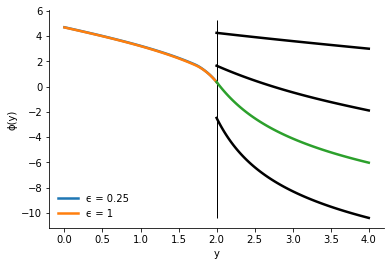

In [41]:
ep_list = [0.25, 1]
for i in range(len(r0_list)):
    plt.plot(y_grid_cap,solu_list[i]['φ'], label='ϵ = {}'.format(ep_list[i]))
plt.plot(y_grid[short_idx:], ϕ_list.T[short_idx:], c='black')
plt.plot(y_grid[short_idx:], ϕ_bound[short_idx:])
# plt.ylim(0)
plt.vlines(2, ymin=np.min(ϕ_list[-1][-1]), ymax=np.max(ϕ_list[0][short_idx])+1, color='black', linewidth=1)
plt.legend()
plt.ylabel('ϕ(y)')
plt.xlabel('y')
# plt.savefig('../figures/value_interval_jump.pdf')

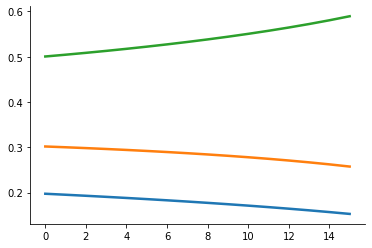

In [65]:
plt.plot(solu_list[-1]['πd'].T[shortest_idx:short_idx+1])

Text(0.5, 0, 'y')

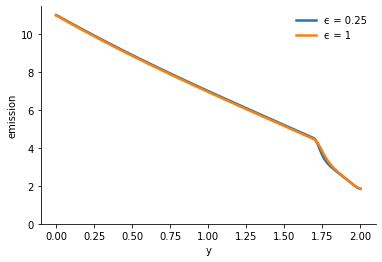

In [42]:
ep_list = [0.25, 1]
for i in range(len(r0_list)):
    plt.plot(y_grid_cap,solu_list[i]['ems'], label='ϵ = {}'.format(ep_list[i]))
plt.ylim(0)
plt.legend()
plt.ylabel('emission')
plt.xlabel('y')
# plt.savefig('../figures/ems_interval_jump.pdf')

In [44]:
ξa = 1/10_000*100
ξw = 1000*100
ξp = 1/20*100
dmg_weight = np.array([1/3, 1/3, 1/3])
ȳ = 2

y_min = 0
y_max = 4
hy = 0.02
y_grid = np.arange(y_min, y_max+hy, hy)
y_short = np.arange(y_min, ȳ+hy, hy)
numy_bar = len(y_short)-1

args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list, π_list = approach_one_100(y_grid, numy_bar, args, report_π=True)
yt, et, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)
solu_orignal = solu
et_original = et
πd_original = πᵈt

episode: 10000,	 ode error: 0.00044409073248848074,	 ft error: 0.0001501373789647431
episode: 5038,	 ode error: 0.00031678354971511474,	 ft error: 9.998391744166687e-09
episode: 5389,	 ode error: 0.0010988225461033745,	 ft error: 9.99224999039446e-09
episode: 10000,	 ode error: 0.0007238119045097358,	 ft error: 0.00014534915273552626


In [45]:
def simulate_ems(y_grid_cap, ems, πd, πc, θ_list, y_start =1 , T=100):
    yt = np.zeros(T)
    et = np.zeros(T)
    πdt = np.zeros((T, len(πd)))
    get_πd = interpolate.interp1d(y_grid_cap, πd)
    πct = np.zeros((T, len(πc)))
    get_πc = interpolate.interp1d(y_grid_cap, πc)
    y = y_start
    for t in range(T):
        
        if y <= np.max(y_grid_cap):
            e_i = np.interp(y, y_grid_cap, ems)
            if y >= np.min(y_grid_cap):
                πd_list = get_πd(y)
                πdt[t] = πd_list
            et[t] = e_i 
            πc_list = get_πc(y)
            πct[t] = πc_list
            yt[t] = y
            y = y + np.mean(θ_list)*e_i
    return yt, et, πdt, πct

In [46]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt
def simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt, T=100, dt=1):
    Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0)
    MCt = (1-η)/((α - invkap)*np.exp(Kt))
    Ct = (α - invkap)*np.exp(Kt)
    SCCt = MEt/MCt*1000
    return SCCt, Ct

In [47]:
simul = []
for i in range(len(r0_list)):
    yt,et,πdt, πct = simulate_ems(y_grid_cap, solu_list[i]['ems'], solu_list[i]['πd'], solu_list[i]['πc'], 
                                  θ_list)
    simul.append(dict(et=et, yt=yt, πdt=πdt, πct=πct))

In [48]:
solu_list[i]['πd'].shape

(3, 101)

Text(0.5, 0, 'Years')

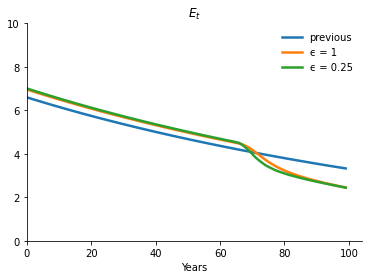

In [52]:
plt.plot(et_original, label='previous')
for i in range(len(r0_list)):
    plt.plot(simul[1-i]['et'], label='ϵ = {}'.format(ep_list[1-i]))


plt.legend()
plt.title('$E_t$')
plt.ylim(0,10)
plt.xlim(0)
plt.xlabel('Years')
# plt.savefig('../figures/ems_interval_jump.pdf')

Text(0.5, 1.0, '$SCC_t$')

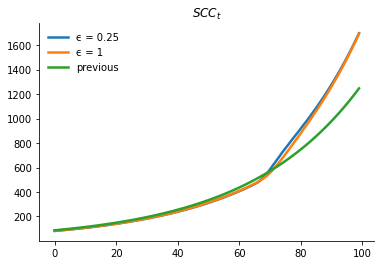

In [50]:
for i in range(len(r0_list)):
    scc, _ = simulate_scc(invkap, αₖ,  σₖ, κ, k0, η/simul[i]['et'])
    plt.plot(scc, label='ϵ = {}'.format(ep_list[i]))
    
scc_original, _ = simulate_scc(invkap, αₖ,  σₖ, κ, k0, η/et_original)
plt.plot(scc_original, label='previous')
plt.legend()
plt.title('$SCC_t$')
# plt.savefig('../figures/SSC_interval_jump.pdf')

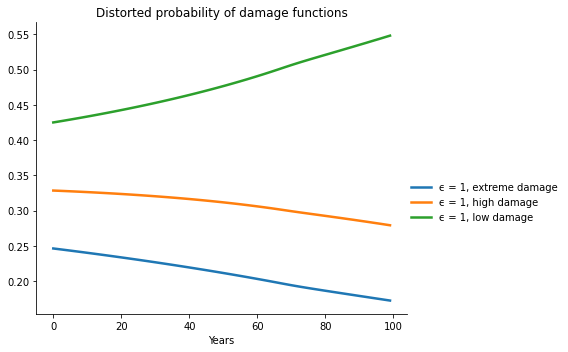

In [62]:
years = np.arange(0,100)
fig = plt.figure(figsize=(8,5))
colors=['tab:red', 'tab:blue', 'tab:green']
for i in range(len(r0_list[1:])):
    for j, dmg in enumerate(['extreme', 'high', 'low']):
        plt.plot(years, simul[i]['πdt'][:,j], label='ϵ = {}, {} damage'.format(ep_list[1], dmg))
    
# scc_original, _ = simulate_scc(invkap, αₖ,  σₖ, κ, k0, η/et_original)
# for j, dmg in enumerate(['extreme', 'high', 'low']):
#     plt.plot(years[simul[i]['πdt'][:, 2-j]>0], πd_original[:,2-j][simul[i]['πdt'][:, 2-j]>0], 
#          label='previous, {} damage'.format(dmg), 
#          color=colors[1], 
# #          label=['low', 'high', 'extreme']
#         )
plt.legend(loc=(1,0.3))
plt.xlabel('Years')
plt.title('Distorted probability of damage functions')
# plt.ylim(0,1)
# plt.xlim(80,100)
fig.tight_layout()
# plt.savefig('../figures/dmg_distort.pdf', alpha=0.5, density=True)
# plt.hist(θ_list*1000, bins=bins, weights=πᶜt[50]*np.exp(-50*δ), color='tab:blue', alpha=0.5)

(0.8, 3.0)

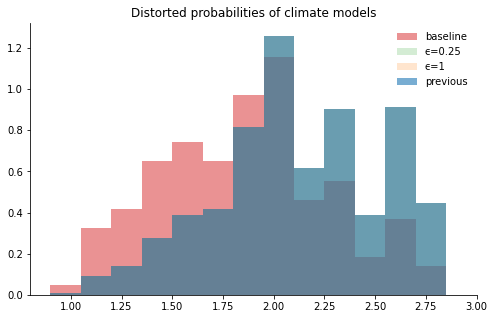

In [54]:
plt.figure(figsize=(8,5))
bins = np.linspace(0, 3, 21)
plt.hist(θ_list*1000, bins=bins, color='tab:red', alpha=0.5, density=True)

plt.hist(θ_list*1000, bins=bins, weights=simul[0]['πct'][50]*np.exp(-50*δ), color='tab:green', alpha=0.2, density=True)
plt.hist(θ_list*1000, bins=bins, weights=simul[1]['πct'][50]*np.exp(-50*δ), color='tab:orange', alpha=0.2, density=True)
plt.hist(θ_list*1000, bins=bins, weights=πᶜt[50]*np.exp(-50*δ), color='tab:blue', alpha=0.6, density=True)
plt.legend(['baseline', 'ϵ=0.25', 'ϵ=1', 'previous', ])
plt.title('Distorted probabilities of climate models')
plt.xlim(0.8,3)
# plt.savefig('../figures/climate_distortion.pdf')

 $$
     \pi_m^{p,*} =  \frac{\pi_m^p\exp(\frac{1}{\xi_p}(\phi - \phi_m))}{\sum\pi_m^p\exp(\frac{1}{\xi_p}(\phi - \phi_m)) }
 $$

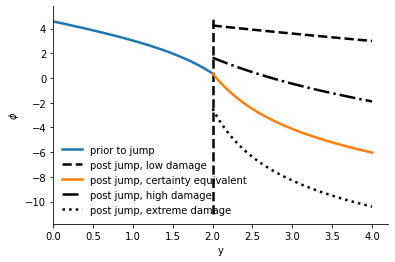

In [55]:
fig,ax3 = plt.subplots()
ϕ = solu["φ"]
ϕ_bound = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)
ϕ_bound = -ξp*np.log(ϕ_bound)
ax3.plot(y_grid[:numy_bar+1], ϕ, label='prior to jump')
ax3.plot(y_grid[numy_bar:], ϕ_list[0][numy_bar:], linestyle="--", color="black", label="post jump, low damage")
ax3.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="post jump, certainty equivalent")
ax3.plot(y_grid[numy_bar:], ϕ_list[1][numy_bar:], linestyle="-.", color="black", label="post jump, high damage")
if np.count_nonzero(dmg_weight) > 2:
    ax3.plot(y_grid[numy_bar:], ϕ_list[-1][numy_bar:], linestyle=":", color="black", label="post jump, extreme damage")
ax3.vlines(x=ȳ, ymin=-11, ymax=5, linestyle="dashed", color="black")
# ax3.xlim(0,4)
# ax3.ylim(-0.02, 0.05)
ax3.set_ylabel('$\phi$')
ax3.set_xlabel('y')
ax3.set_xlim(left=0)
ax3.legend()

(0.0, 6.760975699523007)

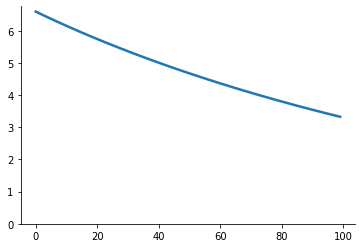

In [60]:
plt.plot(et)
plt.ylim(0)

Checkout another notebook:
[uncertainty decomposition](jump_damage_decompose_minimization_100.ipynb)

(0.8, 3.0)

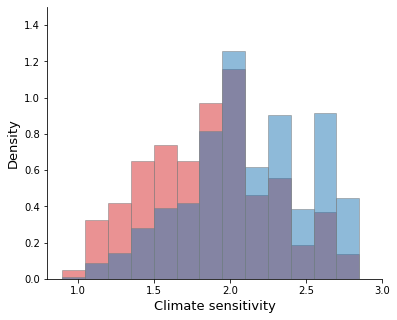

In [22]:
# histogram 10, 50, 90
from matplotlib.ticker import MaxNLocator
fig,ax2 = plt.subplots(1, 1,figsize=(6,5))
# ax1.hist(θ_list*1000, weights=πt_avg[10]*np.exp(-10*δ), density=True, bins=15, color='lightskyblue', ec="grey", alpha=0.8)
# ax1.set_xlabel('Climate sensitivity', fontsize=13)
# ax1.set_ylabel('Distorted density (year 10)', fontsize=13)

# ax1.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
# ax1.set_xlabel('Climate sensitivity', fontsize=13)
# ax1.set_ylabel('Distorted density (year 10)', fontsize=13)
bins = np.linspace(0, 3, 21)

ax2.hist(θ_list*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
ax2.hist(θ_list*1000, weights=πᶜt[50]*np.exp(-δ*50), bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
ax2.set_xlabel('Climate sensitivity', fontsize=13)
ax2.set_ylabel('Density', fontsize=13)
# ax2.set_title('Mean difference: {:.2f} '.format( (θ_list@πᶜt[50]-np.mean(θ_list) + σy*ht[50])*1000 ) )
ax2.set_ylim(0,1.5)
ax2.set_xticks(np.arange(0,3+0.5, 0.5))
ax2.set_xlim(0.8, 3)
# ax2.hist(θ_list*1000, weights=πᶜt[50]*np.exp(-50*δ), density=True, bins=np.linspace(1,3,14), color="tab:blue", ec="grey", alpha=0.5)
# ax2.set_xlabel('Climate sensitivity', fontsize=13)
# ax2.set_ylabel('Distorted density (year 50)', fontsize=13)
# ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax2.hist(θ_list*1000, density=True, bins=np.linspace(1,3,14), color="tab:red", ec="grey", alpha=0.5)
# ax2.set_xlabel('Climate sensitivity', fontsize=13)
# ax2.set_ylabel('Distorted density (year 50)', fontsize=13)



# ax3.hist(θ_list*1000, weights=πt_avg[90]*np.exp(-90*δ), density=True, bins=15, color="lightskyblue", ec="grey", alpha=0.6)
# ax3.set_xlabel('Climate sensitivity', fontsize=13)
# ax3.set_ylabel('Distorted density (year 90)', fontsize=13)

# ax3.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
# ax3.set_xlabel('Climate sensitivity', fontsize=13)
# ax3.set_ylabel('Distorted density (year 90)', fontsize=13)

# plt.savefig('./paper_plots/histogram_worstcase.pdf')

(0.8, 3.0)

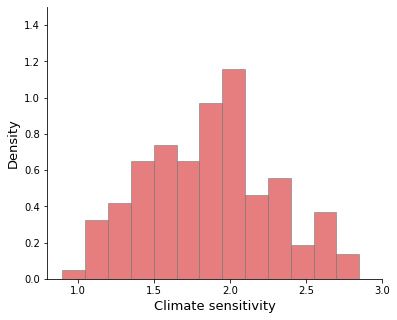

In [23]:
# histogram θ_list
fig,ax2 = plt.subplots(1, 1,figsize=(6,5))
# ax1.hist(θ_list*1000, weights=πt_avg[10]*np.exp(-10*δ), density=True, bins=15, color='lightskyblue', ec="grey", alpha=0.8)
# ax1.set_xlabel('Climate sensitivity', fontsize=13)
# ax1.set_ylabel('Distorted density (year 10)', fontsize=13)

# ax1.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
# ax1.set_xlabel('Climate sensitivity', fontsize=13)
# ax1.set_ylabel('Distorted density (year 10)', fontsize=13)
bins = np.linspace(0, 3, 21)

ax2.hist(θ_list*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.6, density=True)
# ax2.hist(θ_list*1000, weights=πᶜt[50], bins=bins, color='tab:blue', histtype='bar', ec='darkgray', alpha=.5, density=True)
ax2.set_xlabel('Climate sensitivity', fontsize=13)
ax2.set_ylabel('Density', fontsize=13)
# ax2.set_title('Mean difference: {:.2f} '.format( (θ_list@πᶜt[50]-np.mean(θ_list) + σy*ht[50])*1000 ) )
ax2.set_ylim(0,1.5)
ax2.set_xticks(np.arange(0,3+0.5, 0.5))
ax2.set_xlim(0.8, 3)

# plt.savefig('./paper_plots/histogram.pdf')

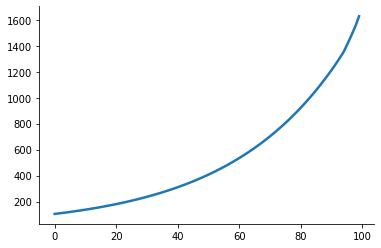

In [50]:
MEt = η/et
SCCt, Ct = simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt, T=100, dt=1)
plt.plot(SCCt)

In [14]:
ξa = 1/10_000*100
ξw = 1000*100
ξp = 1/20*100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_unreveal, ems_unreveal, π_unreveal = solve_smooth_unreveal(y_grid, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 694,	 ode error: 0.0008695666923007328,	 ft error: 9.965709146797508e-08


In [45]:
def simulate_unreveal(y_grid, ems, π, me, θ_list, y_start=1, T=100, dt=1):
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πt = np.zeros((periods, len(π)))
    me_t = np.zeros(periods)
    get_π = interpolate.interp1d(y_grid, π)
#     y = np.mean(θ_list)*290
    y = y_start
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            π_list = get_π(y)
            if me is not None:
                me_point = np.interp(y, y_grid, me)
                me_t[t] = me_point
            et[t] = ems_point
            πt[t] = π_list
            
            yt[t] = y
            dy = ems_point*np.mean(θ_list)*dt
            y = dy + y
    
    return yt, et, πt, me_t

In [16]:
logKt = simulate_logkapital(invkap, αₖ,  σₖ, κ, k0,)

In [17]:
yt_unreveal, et_unreveal, πt_unreveal, _ = simulate_unreveal(y_grid, ems_unreveal, π_unreveal, None, θ_list, T=200)

Text(0.5, 1.0, 'Emission trajectories \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold')

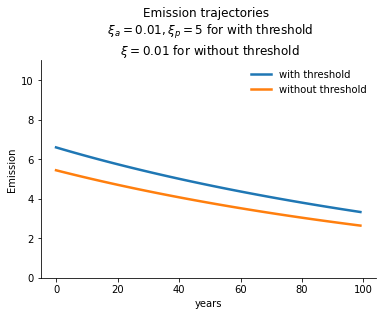

In [18]:
plt.plot(et[et>0], label="with threshold")
plt.plot(et_unreveal[:100], label="without threshold")
plt.ylim(0,11)
plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("Emission")
plt.title("Emission trajectories \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold")
# plt.savefig("./paper_plots/ems_nojumpcompare.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 1.0, '$Y_t$ trajectories \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold')

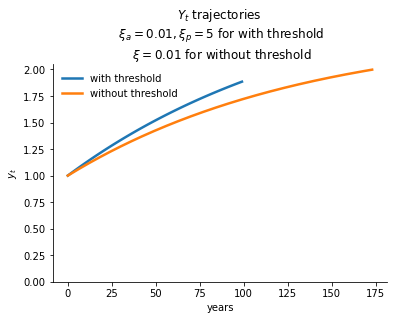

In [19]:
plt.plot(yt[yt>0], label="with threshold")
plt.plot(yt_unreveal[yt_unreveal<=2], label="without threshold")
plt.ylim(0)
plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("$y_t$")
plt.title("$Y_t$ trajectories \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold")
# plt.savefig("./paper_plots/ems_nojumpcompare.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 1.0, 'SCC \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold')

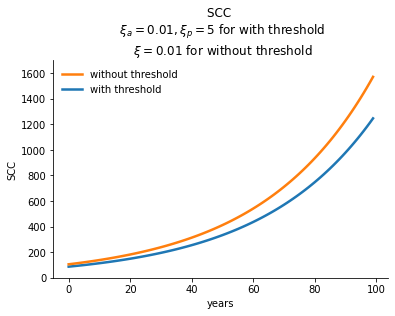

In [20]:
SCCt_unreveal = η*(α - invkap)*np.exp(logKt)/(1-η)/et_unreveal[:100]*1000
plt.plot(SCCt, label="with threshold")
plt.plot(SCCt_unreveal, label="without threshold")
plt.ylim(0,1700)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("SCC")
plt.title("SCC \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold")
# plt.savefig("./paper_plots/scc_nojumpcompare.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

In [21]:
ξa = 1000*100
ξw = 1000*100
ξp = 1000*100
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args,)
yt_base, et_base, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 10000,	 ode error: 0.00011710457906673188,	 ft error: 0.00012173167466637362
episode: 5012,	 ode error: 0.000328243742822254,	 ft error: 9.970615444387931e-09
episode: 5377,	 ode error: 0.0011686487381849346,	 ft error: 9.996075078788635e-09
episode: 1227,	 ode error: 0.000521663011021703,	 ft error: 9.933103228831897e-09


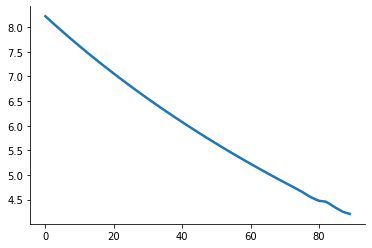

In [28]:
plt.plot(et_base[et_base>0])

In [22]:
ξa = 1000*100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_unreveal_base, ems_unreveal_base, π_unreveal_base = solve_smooth_unreveal(y_grid, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 681,	 ode error: 0.000652568780844253,	 ft error: 9.846339643626578e-08


In [25]:
yt_unreveal_base, et_unreveal_base, πt_unreveal_base, _ = simulate_unreveal(y_grid, ems_unreveal_base, π_unreveal_base, None, θ_list, T=200)

Text(0.5, 1.0, 'Emission trajectories \n $ξ_a = \\infty, ξ_p = \\infty$ for with jump\n $ξ =\\infty$ for without jump')

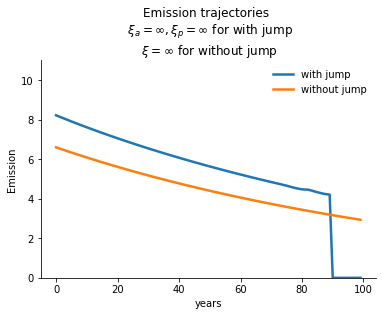

In [26]:
plt.plot(et_base, label="with jump")
plt.plot(et_unreveal_base[:100], label="without jump")
plt.ylim(0,11)
plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("Emission")
plt.title("Emission trajectories \n $ξ_a = \infty, ξ_p = \infty$ for with jump\n $ξ =\infty$ for without jump")
# plt.savefig("./paper_plots/ems_nojumpcompare_base.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

<ipython-input-31-e599f94ff8f7>:1: RuntimeWarning: divide by zero encountered in true_divide
  SCCt_base = η*(α - invkap)*np.exp(logKt)/(1-η)/et_base*1000


Text(0.5, 1.0, 'SCC \n $ξ_a = \\infty, ξ_p = \\infty$ for with jump\n $ξ = \\infty$ for without jump')

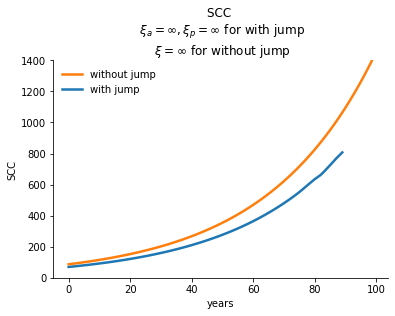

In [31]:
SCCt_base = η*(α - invkap)*np.exp(logKt)/(1-η)/et_base*1000
SCCt_unreveal_base = η*(α - invkap)*np.exp(logKt)/(1-η)/et_unreveal_base[:100]*1000
plt.plot(SCCt_base, label="with jump")
plt.plot(SCCt_unreveal_base, label="without jump")
plt.ylim(0,1400)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("SCC")
plt.title("SCC \n $ξ_a = \infty, ξ_p = \infty$ for with jump\n $ξ = \infty$ for without jump")
# plt.savefig("./paper_plots/scc_nojumpcompare_base.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

In [33]:
n_climate = len(θ_list)
n_dmg = len(γ3_list)
πc_dict = dict()
for year in [10,50,90, -1]:
    πc_dict[year] = np.sum(πt_unreveal[year].reshape(n_climate, n_dmg), axis=1)

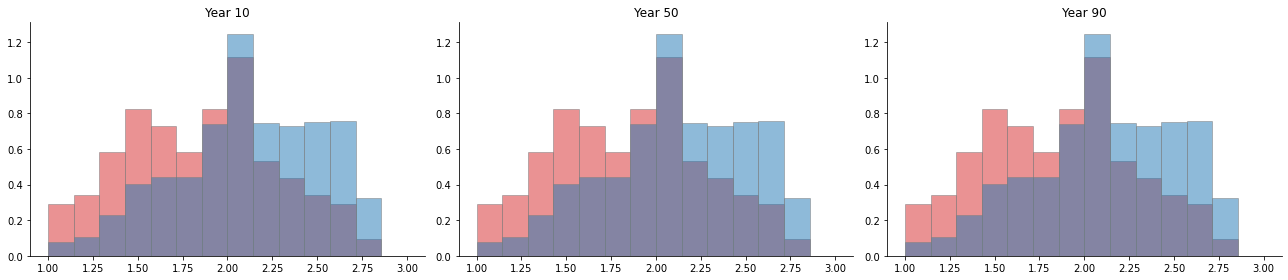

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
axes = [ax1, ax2, ax3]
bins=np.linspace(1,3,15)
ax1.set_title("Year 10")
ax1.hist(θ_list*1000, density=True, bins=bins, alpha=0.5, ec="gray", color="tab:red" )
ax1.hist(θ_list*1000, weights=πc_dict[10], bins=bins, density=True, alpha=0.5, ec="gray", color="tab:blue")

ax2.set_title("Year 50")
ax2.hist(θ_list*1000, density=True, bins=bins, alpha=0.5, ec="gray",color="tab:red" )
ax2.hist(θ_list*1000, weights=πc_dict[50]*np.exp(-50*δ), bins=bins, density=True, alpha=0.5, ec="gray",color="tab:blue")

ax3.set_title("Year 90")
ax3.hist(θ_list*1000, density=True, bins=bins, alpha=0.5, ec="gray", color="tab:red" )
ax3.hist(θ_list*1000, weights=πc_dict[90]*np.exp(-90*δ), bins=bins, density=True, alpha=0.5, ec="gray", color="tab:blue")

fig.tight_layout()
# fig.savefig("./paper_plots/hist_time.png", facecolor="w",dpi=500)

In [35]:
πd_list = np.zeros((200,3))
for year in range(200):
    πd_list[year] = np.sum(πt_unreveal[year].reshape(n_climate, n_dmg), axis=0)

# Decompose  for no jump version

In [36]:
def solve_smooth_unreveal_decompose(y_grid, ems_star, args, max_iter, tol, ϵ,):
    """
    solve for step one, ϕⱼ for individual damage function
    
    Parameter
    ---
    args: δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξa, ξw
    """
    δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw = args
    params = list()
    for θ_i in θ_list:
        for γ3 in γ3_list:
            params.append([θ_i, γ3])
    params = np.array(params)
    θ_long = params[:,0]
    γ3_long = params[:,1]
    args_weight = (δ, η, γ1, γ2, ȳ, σy, ξa)
    dy = y_grid[1] - y_grid[0]
    n_y = len(y_grid)
#     dΛ = γ1 + γ2*y_grid + γ3*(y_grid-ȳ)*(y_grid>ȳ)
#     ddΛ = γ2 + γ3*(y_grid>ȳ)
    ϕ = - η*y_grid**2
    ems = η
    ems_old = ems
    πo = np.ones((len(params), n_y))/len(params)
    lhs_error = 1
    episode = 0
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, "up")
        dϕdyy = derivative_1d(ϕ, 2, dy, "up")
#         temp1 = dϕdy + (η-1)/δ*dΛ
#         temp2 = dϕdyy + (de)
        # update belief
        weight = generate_weight(params, ems_star, dϕdy, y_grid, args_weight)
        π = πo*np.exp(weight)
        π[π <= 1e-15] = 1e-15
        π = π/np.sum(π, axis=0)
        # update control
#         temp = dϕdy + (η-1)/δ*(γ1 + γ2*y_grid)
#         ddΛ = γ2 + γ3_long@π*(y_grid>ȳ)
#         a = (dϕdyy  + (η-1)/δ*ddΛ)*σy**2
#         b = (θ_long@π)*temp + (η-1)/δ*((θ_long*γ3_long)@π)*(y_grid - ȳ)*(y_grid>ȳ)
#         c = η
#         Δ = b**2 - 4*a*c
#         Δ[Δ < 0] = 0
#         root1 = (-b - np.sqrt(Δ))/(2*a)
#         root2 = (-b + np.sqrt(Δ))/(2*a)
#         if root1.all() > 0:
#             ems_new = root1
#         else:
#             ems_new = root2
#         ems_new[ems_new < 1e-15] = 1e-15
#         ems = ems_new*0.5 + ems_old*0.5
        # solve for ode
        dmg_drift = θ_long@π*(γ1 + γ2*y_grid)*ems_star + (θ_long*γ3_long)@π*(y_grid-ȳ)*(y_grid>ȳ)*ems_star\
        + 1/2*(γ3_long@π)*(y_grid>ȳ)*σy**2*ems_star**2 + 1/2*γ2*σy**2*ems_star**2
        A = - δ*np.ones(y_grid.shape)
        B = (θ_long@π)*ems_star
#         C = np.zeros(y_grid.shape)
        C = ems_star**2*σy**2/2
        D = η*np.log(ems_star) + ξa*np.sum(π*(np.log(π) - np.log(πo)), axis=0)\
            + (η-1)/δ*dmg_drift
#         - 1/(2*ξw)*temp**2*ems**2*σy**2\
#         + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
#         ems_old = ems
        episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    me = - θ_long@π*(dϕdy + (η-1)/δ*(γ1 + γ2*y_grid)) - (η-1)/δ*(θ_long*γ3_long)@π*(y_grid-ȳ)*(y_grid>ȳ) \
        - (η-1)/δ*(γ3_long@π)*(y_grid>ȳ)*σy**2*ems_star - (η-1)/δ*γ2*σy**2*ems_star - dϕdyy*σy**2*ems_star
#     h = - temp*ems*σy/ξw
    return ϕ, ems, π, me

In [37]:
ξa = 1/100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_test, ems_test, π_test, me_unreveal = solve_smooth_unreveal_decompose(y_grid, ems_unreveal, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 694,	 ode error: 0.0008695669350341304,	 ft error: 9.959527069725027e-08


In [38]:
ems_10 = 10*np.ones(ems_unreveal.shape)

In [39]:
ems = ems_unreveal
# ems = ems_10

In [44]:
# base
ξa = 1000*100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_b, ems_b, π_b, me_b = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 681,	 ode error: 0.0005883286089622009,	 ft error: 9.537113232482852e-08


In [45]:
# dmamage 
ξa = 1/100
args_unreveal = (δ, η, [np.average(θ_list)], σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_dmg, ems_dmg, π_dmg, me_dmg = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 5000,	 ode error: 0.0007692703380716287,	 ft error: 2.826561062840849e-05


In [46]:
# temp
ξa = 1/100
args_unreveal = (δ, η, θtemp_list, σy, γ1, γ2, [np.average(γ3_list)], ȳ, ξa, ξw)
ϕ_temp, ems_temp, π_temp, me_temp = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 688,	 ode error: 0.0006117452360071673,	 ft error: 9.824843516526016e-08


In [47]:
# carb
ξa = 1/100
args_unreveal = (δ, η, θcarb_list, σy, γ1, γ2, [np.average(γ3_list)], ȳ, ξa, ξw)
ϕ_carb, ems_carb, π_carb, me_carb = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 687,	 ode error: 0.0005965204360334053,	 ft error: 9.99169396109778e-08


In [48]:
# total
ξa = 1/100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_total, ems_total, π_total, me_total = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 694,	 ode error: 0.0008695669350341304,	 ft error: 9.959527069725027e-08


In [49]:
yt_b, et_b, πt_b, met_b = simulate_unreveal(y_grid, ems, π_b, me_b, θ_list, T=200)
yt_dmg, et_dmg, πt_dmg, met_dmg = simulate_unreveal(y_grid, ems, π_dmg, me_dmg, θ_list, T=200)
yt_temp, et_temp, πt_temp, met_temp = simulate_unreveal(y_grid, ems, π_temp, me_temp, θ_list, T=200)
yt_carb, et_carb, πt_carb, met_carb = simulate_unreveal(y_grid, ems, π_carb, me_carb, θ_list, T=200)
yt_total, et_total, πt_total, met_total = simulate_unreveal(y_grid, ems, π_total, me_total, θ_list, T=200)

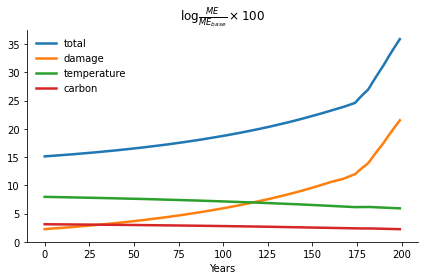

In [50]:
plt.plot(np.log(met_total/met_b)*100, label="total")
plt.plot(np.log(met_dmg/met_b)*100, label="damage")
plt.plot(np.log(met_temp/met_b)*100, label="temperature")
plt.plot(np.log(met_carb/met_b)*100, label="carbon")
plt.ylim(0)
plt.xlabel("Years")
plt.legend(frameon=False)
plt.title("$\\log \\frac{ME}{ME_{base}} \\times 100$")
plt.tight_layout()
# plt.savefig("./paper_plots/decomp_1type_21.png", dpi=500, facecolor="w")

Text(0.5, 1.0, '$\\log \\frac{ME}{ME_{base}} \\times 100$')

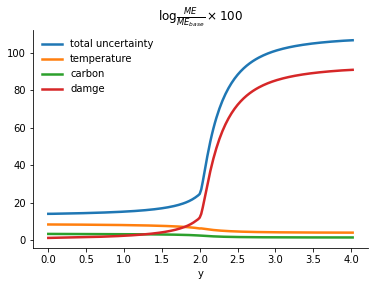

In [51]:
plt.plot(y_grid, np.log(me_total/me_b)*100, label="total uncertainty")
plt.plot(y_grid, np.log(me_temp/me_b)*100, label="temperature")
plt.plot(y_grid, np.log(me_carb/me_b)*100, label="carbon")
plt.plot(y_grid, np.log(me_dmg/me_b)*100, label="damge")
plt.xlabel("y")
plt.legend(frameon=False)
plt.title("$\\log \\frac{ME}{ME_{base}} \\times 100$")

In [52]:
# dmamage and temp
ξa = 1/100
args_unreveal = (δ, η, θtemp_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_tempdmg, ems_tempdmg, π_tempdmg, me_tempdmg = solve_smooth_unreveal_decompose(y_grid, ems, 
                                                                                args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 694,	 ode error: 0.0008360410378625491,	 ft error: 9.874248796393204e-08


In [53]:
# dmamage and carb
ξa = 1/100
args_unreveal = (δ, η, θcarb_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_carbdmg, ems_carbdmg, π_carbdmg, me_carbdmg = solve_smooth_unreveal_decompose(y_grid, ems, 
                                                                                args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 693,	 ode error: 0.0007965239294456961,	 ft error: 9.950145329895577e-08


In [54]:
# temp and carb
ξa = 1/100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, [np.average(γ3_list)], ȳ, ξa, ξw)
ϕ_tempcarb, ems_tempcarb, π_tempcarb, me_tempcarb = solve_smooth_unreveal_decompose(y_grid, ems, 
                                                                                    args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 688,	 ode error: 0.0006244045825355357,	 ft error: 9.841302439639321e-08


In [55]:
yt_carbdmg, et_carbdmg, πt_carbdmg, met_carbdmg = simulate_unreveal(y_grid, ems, π_carbdmg, me_carbdmg, θ_list, T=200)
yt_tempcarb, et_tempcarb, πt_tempcarb, met_tempcarb = simulate_unreveal(y_grid, ems, π_tempcarb, me_tempcarb, θ_list, T=200)
yt_tempdmg, et_tempdmg, πt_tempdmg, met_tempdmg = simulate_unreveal(y_grid, ems, π_tempdmg, me_tempdmg, θ_list, T=200)

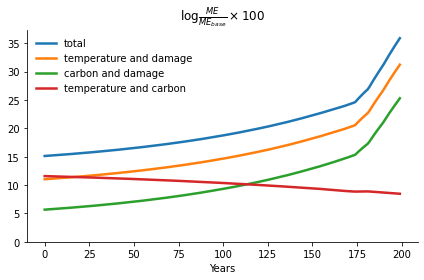

In [56]:
plt.plot(np.log(met_total/met_b)*100, label="total")
plt.plot(np.log(met_tempdmg/met_b)*100, label="temperature and damage")
plt.plot(np.log(met_carbdmg/met_b)*100, label="carbon and damage")
plt.plot(np.log(met_tempcarb/met_b)*100, label="temperature and carbon")
# plt.plot(np.log(met_tempcarb/met_b)*100, label="temperature and carbon"))
plt.ylim(0)
plt.xlabel("Years")
plt.legend(frameon=False)
plt.title("$\\log \\frac{ME}{ME_{base}} \\times 100$")
plt.tight_layout()
# plt.savefig("./paper_plots/decomp_2type_21.png", facecolor="w", dpi=500)

Text(0.5, 1.0, '$\\log \\frac{ME}{ME_{base}} \\times 100$')

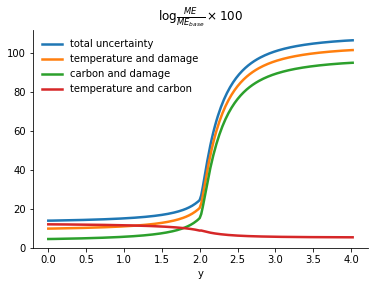

In [57]:
plt.plot(y_grid, np.log(me_total/me_b)*100, label="total uncertainty")
plt.plot(y_grid, np.log(me_tempdmg/me_b)*100, label="temperature and damage")
plt.plot(y_grid, np.log(me_carbdmg/me_b)*100, label="carbon and damage")
plt.plot(y_grid, np.log(me_tempcarb/me_b)*100, label="temperature and carbon")
plt.xlabel("y")
plt.ylim(0)
plt.legend(frameon=False)
plt.title("$\\log \\frac{ME}{ME_{base}} \\times 100$")

# SCC uncertainty decomposition: pre jump

First order condition for $\tilde e$

$$
    \left( \frac{d^2\phi(y)}{dy^2} + \frac{(\eta-1)}{\delta}\cdot\gamma_2  \right)|\sigma_y|^2\tilde e + \sum_j \pi^c_j \left[\frac{d\phi(y)}{dy} + \frac{(\eta - 1)}{\delta}(\gamma_1 + \gamma_2 y)\right]\theta_j  + \frac{\eta}{\tilde e} = 0 \tag{$\ast$}
$$

Call solution $\tilde e^* $. Now solve:
$$
\begin{aligned}
0 =  & - \delta \color{red}{\phi(y)}+ \eta \log\tilde e^* + \frac{1}{2} \color{red}{ \frac{d^2 \phi}{dy^2}}\cdot(\tilde e^*)^2 |\sigma_y|^2 + \frac{1}{2}\frac{(\eta -1)}{\delta}\gamma_2(\tilde e^*)^2 |\sigma_y|^2\\
& + \left[\color{red}{\frac{d\phi}{dy}}  + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)\right] \tilde e^* \sum_i \pi_i^c \theta_i
\end{aligned}
$$

In [58]:
def plot_together(et, θ_list, ht, πᶜt, πᵈt, MEt, dmg_weight):
    y_grid_cap = y_grid[:numy_bar+1]
    πᶜo = πᶜo = np.ones(len(θ_list))/len(θ_list)
    # plot
    fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,8))
    fig.tight_layout(pad=5)
    # plot 1
    if np.count_nonzero(dmg_weight) > 2:
        ax1.plot(πᵈt[:,-1], label="extreme damage", color="C2")
    ax1.plot(πᵈt[:,1], label="high damage", color="C3")
    ax1.plot(πᵈt[:,0], label="low", color="C0")
    ax1.legend(frameon=False)
    ax1.set_xlabel('Years')
    ax1.set_ylim(0,1)
    ax1.set_xlim(left=0)
    ax1.set_title('distorted probability of damage')
    # plot 2
    bins = np.linspace(1,3,14)
    ax2.hist(θ_list*1000, density=True, color='tab:red', bins=bins, histtype='bar', ec='gray', alpha=.5, )
    ax2.hist((θ_list+σy*ht[49])*1000, weights=πᶜt[49], density=True, color='tab:blue',bins=bins, histtype='bar', ec='gray', alpha=.5,)
    ax2.set_title('mean difference: {:.4f}'.format((θ_list@(πᶜt[49]-πᶜo)+σy*ht[49])*1000))
    ax2.set_xlabel('Climate sensitivity, year 50')
    ax2.set_xlim(0.8,3)
    # plot 3
    ax3.plot(et[et_base>0],label='distorted', color="C3")
    ax3.plot(et_base[et_base>0], label="baseline", color="C0")
    ax3.legend(frameon=False)
    ax3.set_xlabel('Years')
    ax3.set_ylim(bottom=0)
    ax3.set_xlim(left=0)
    ax3.set_title('emission')
    # plot 4
    SCCt_base, _ = simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt)
    SCCt_distorted, _ = simulate_scc(invkap, αₖ,  σₖ, κ, k0, δ*η/et)
#     ax4.plot((δ*η/et[et>0])/MC[et>0]*1000, label="total", color="C3")
    ax4.plot(SCCt_distorted, label="total", color="C3")
#     ax4.plot((ME/MC)[et>0]*1000, label="baseline", color="C0")
    ax4.plot(SCCt_distorted - SCCt_base, label="baseline", color="C0")
    ax4.legend(frameon=False)
    ax4.set_xlabel('Years')
    ax4.set_ylim(bottom=0)
    ax4.set_xlim(left=0)
    ax4.set_title('social cost of carbon')
    
    return fig, ((ax1, ax2), (ax3, ax4))

In [59]:
def simulate_jump_ems(y_grid, solu, ME,  θ_list, T=100, dt=1):
    ems = solu["ems"]
    πᶜ = solu["πc"]
    πᵈ = solu["πd"]
    ι = solu["ι"]
    h = solu["h"]
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πᶜt = np.zeros((periods, len(θ_list)))
    πᵈt = np.zeros((periods, len(πᵈ)))
    ιt = np.zeros(periods)
    ht = np.zeros(periods)
    if ME is not None:
        me_t = np.zeros(periods)
    # interpolate
    get_πᵈ = interpolate.interp1d(y_grid, πᵈ)
    get_πᶜ = interpolate.interp1d(y_grid, πᶜ)
#     y = np.mean(θ_list)*290
    y=1
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            πᵈ_list = get_πᵈ(y)
            πᶜ_list = get_πᶜ(y)
            ι_point = np.interp(y, y_grid, ι)
            h_point = np.interp(y, y_grid, h)
            if ME is not None:
                me_point = np.interp(y, y_grid, ME)
                me_t[t] = me_point
            et[t] = ems_point
            πᵈt[t] = πᵈ_list
            πᶜt[t] = πᶜ_list
            ιt[t] = ι_point
            ht[t] = h_point
            yt[t] = y
            dy = ems_point*(θ_list@πᶜ_list + σy*h_point)*dt
            y = dy + y
    if ME is not None:
        return yt, et, πᵈt, πᶜt, ιt, ht, me_t
    else:
        return yt, et, πᵈt, πᶜt, ιt, ht

In [154]:
ξa = 100000
ξw = 100000
ξp = 100000
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=3, max_iter=5000)
yt_bb, et_bb, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)
yt_bbw, et_bbw, πᵈt, πᶜt, ιt, ht = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 5000,	 ode error: 7.325914529324185e-05,	 ft error: 1.8219840886383547e-06
episode: 5000,	 ode error: 0.00023532655471273506,	 ft error: 4.188143125401685e-05
episode: 5000,	 ode error: 0.0011036955102757809,	 ft error: 2.729011709945439e-07
episode: 5000,	 ode error: 0.0005675509551250346,	 ft error: 5.34225959617866e-06


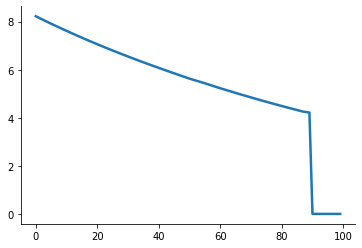

In [155]:
plt.plot(et_bb)

In [138]:
ξa = 100000
ξw = 0.3
ξp = 5
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, max_iter=5_000)
yt_3, et_3, πᵈt, πᶜt_3, ιt, ht_3 = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)
yt_3w, et_3w, πᵈt, πᶜt_3, ιt, ht_3w = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 5000,	 ode error: 0.0005104346301074425,	 ft error: 2.3678546477630867e-05
episode: 5000,	 ode error: 0.00023846874503928583,	 ft error: 0.00010943308729268372
episode: 5000,	 ode error: 0.000987460360670117,	 ft error: 3.1945338226554064e-08
episode: 1474,	 ode error: 0.0006519126084000362,	 ft error: 9.824745461628481e-09


In [139]:
# adding equal version 1 
ξa = 100000
ξw = 0.3
ξp = 0.3
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=2, max_iter=5_000)
yt_e1, et_e1, πᵈt, πᶜt, ιt, ht_e1 = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list,)
yt_e1w, et_e1w, πᵈt, πᶜt, ιt, ht_e1w = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 5000,	 ode error: 5.814652399450948e-05,	 ft error: 1.9997413803984898e-05
episode: 760,	 ode error: 0.0002837755205893633,	 ft error: 9.97730731366886e-09
episode: 817,	 ode error: 0.0009680955968403412,	 ft error: 9.804258738199678e-09
episode: 5000,	 ode error: 0.001879725126314011,	 ft error: 6.641312343402817e-07


In [140]:
# adding equal version 2
ξa = 1000*100
ξw = 1/20*100
ξp = 1/20*100
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=2, max_iter=5_000)
yt_e2, et_e2, πᵈt, πᶜt, ιt, ht_e2 = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list,)
yt_e2w, et_e2w, πᵈt, πᶜt, ιt, ht_e2w = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 3177,	 ode error: 8.894208216329857e-05,	 ft error: 9.778538423432792e-09
episode: 5000,	 ode error: 0.000241901747241903,	 ft error: 5.0170904475344e-05
episode: 814,	 ode error: 0.0010729152681469697,	 ft error: 9.739547834897166e-09
episode: 5000,	 ode error: 0.0007893408641111016,	 ft error: 4.773217333498003e-06


Text(0.5, 0, 'Years')

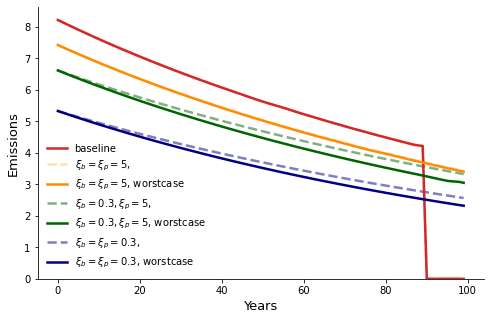

In [156]:
#
dt=1
years = np.arange(0,100,dt)
fig = plt.figure(figsize=(8,5))
plt.plot(years, et_bb, label="baseline", color="tab:red", alpha=0.3, linestyle="dashed")
plt.plot(years, et_e2, label="$ξ_b = ξ_p = 5$,", color="darkorange", alpha=0.3, linestyle="dashed")
# plt.plot(et_brownian, label="brownian robust, jump robust", color="tab:blue")
# plt.plot(et_smooth, label="smooth ambiguity, jump robust", color="darkgreen")
plt.plot(years, et_3, label="$ξ_b =0.3,  ξ_p = 5$,", color="darkgreen", alpha=0.5, linestyle="dashed")
plt.plot(years, et_e1, label="$ξ_b = ξ_p = 0.3$, " , color="navy", alpha=0.5, linestyle="dashed")


plt.plot(et_bbw, label="baseline", color="tab:red")
plt.plot(et_e2w, label="$ξ_b = ξ_p = 5$, worstcase", color="darkorange")
# plt.plot(et_brownian, label="brownian robust, jump robust", color="tab:blue")
# plt.plot(et_smooth, label="smooth ambiguity, jump robust", color="darkgreen")
plt.plot(et_3w, label="$ξ_b =0.3,  ξ_p = 5$, worstcase", color="darkgreen")
plt.plot(et_e1w, label="$ξ_b = ξ_p = 0.3$, worstcase" , color="navy")


# plt.plot(et, label="with drift term + jump robust")
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,1,5,2,6,3,7,]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False, loc=3)
# plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel('Emissions', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.savefig("./paper_plots/emission_three.pdf")
# plt.savefig("./paper_plots/emission.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Years')

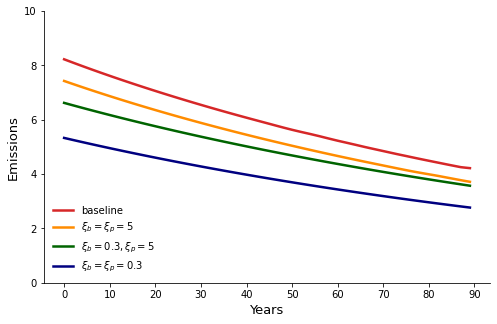

In [157]:
#
fig = plt.figure(figsize=(8,5))
plt.plot(years[et_bb>0], et_bb[et_bb>0], label="baseline", color="tab:red")
plt.plot(years[et_bb>0], et_e2[et_bb>0], label="$ξ_b = ξ_p = 5$", color="darkorange")
# plt.plot(et_brownian, label="brownian robust, jump robust", color="tab:blue")
# plt.plot(et_smooth, label="smooth ambiguity, jump robust", color="darkgreen")
plt.plot(years[et_bb>0], et_3[et_bb>0], label="$ξ_b =0.3,  ξ_p = 5$", color="darkgreen")
plt.plot(years[et_bb>0], et_e1[et_bb>0], label="$ξ_b = ξ_p = 0.3$" , color="navy")

# plt.plot(et, label="with drift term + jump robust")
plt.legend(frameon=False, loc=3)
plt.ylim(0,10)
# plt.xlim(right=95)
plt.xticks(np.arange(0, 91, 10))
plt.ylabel('Emissions', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.savefig("./paper_plots/emission_three.pdf")
# plt.savefig("./paper_plots/emission_five.png", facecolor="w", edgecolor="w", bbox_inches="tight")

<ipython-input-147-07b4531d649b>:11: RuntimeWarning: divide by zero encountered in log
  plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η), label="baseline", color="tab:red")


Text(0.5, 0, 'Years')

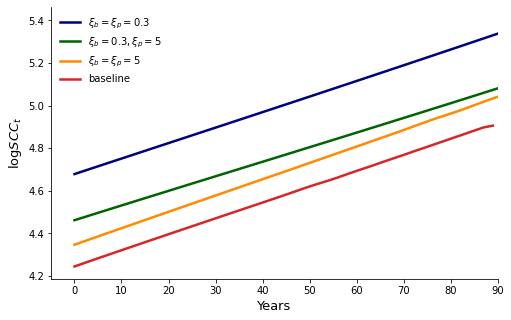

In [147]:
#
fig = plt.figure(figsize=(8,5))
# plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_browian*γ1 + γ2/2*yt_browian**2) - np.log(et_brownian) + np.log(η) - np.log(1 -η), label="brownian robust, jump robust", color="tab:blue")
# plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_smooth*γ1 + γ2/2*yt_smooth**2) - np.log(et_smooth) + np.log(η) - np.log(1 -η), label="smooth ambiguity, jump robust", color="darkgreen")


plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_e1*γ1 + γ2/2*yt_e1**2) -np.log(et_e1) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 0.3$", color="navy")
plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_3*γ1 + γ2/2*yt_3**2) -np.log(et_3) + np.log(η) - np.log(1- η), label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_e2*γ1 + γ2/2*yt_e2**2) -np.log(et_e2) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 5$", color="darkorange")
plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η), label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
# plt.ylim(0)
plt.xticks(np.arange(0,91,10))
plt.xlim(right=90)
plt.ylabel('$\log SCC_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/logscc_five.png", facecolor="w", edgecolor="w", bbox_inches="tight")

<ipython-input-130-90203d04de5d>:8: RuntimeWarning: divide by zero encountered in log
  plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η), label="baseline, baseline", color="tab:red", alpha=0.5, linestyle="dashed")
<ipython-input-130-90203d04de5d>:14: RuntimeWarning: divide by zero encountered in log
  plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_bbw*γ1 + γ2/2*yt_bbw**2) -np.log(et_bbw) + np.log(η) - np.log(1- η), label="baseline", color="tab:red")


Text(0.5, 0, 'Years')

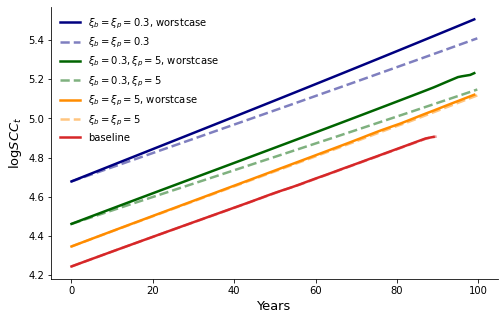

In [130]:
#
fig = plt.figure(figsize=(8,5))

plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_e1*γ1 + γ2/2*yt_e1**2) -np.log(et_e1) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 0.3$", color="navy", alpha=0.5, linestyle="dashed")
plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_3*γ1 + γ2/2*yt_3**2) -np.log(et_3) + np.log(η) - np.log(1- η), label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen", alpha=0.5, linestyle="dashed")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_e2*γ1 + γ2/2*yt_e2**2) -np.log(et_e2) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 5$", color="darkorange", alpha=0.5, linestyle="dashed")
plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η), label="baseline, baseline", color="tab:red", alpha=0.5, linestyle="dashed")

plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_e1w*γ1 + γ2/2*yt_e1w**2) -np.log(et_e1w) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 0.3$, worstcase", color="navy")
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_3w*γ1 + γ2/2*yt_3w**2) -np.log(et_3w) + np.log(η) - np.log(1- η), label="$ξ_b =0.3, ξ_p = 5$, worstcase", color="darkgreen")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_e2w*γ1 + γ2/2*yt_e2w**2) -np.log(et_e2w) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 5$, worstcase", color="darkorange")
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_bbw*γ1 + γ2/2*yt_bbw**2) -np.log(et_bbw) + np.log(η) - np.log(1- η), label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,0,5,1,6,2,7,]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
# plt.ylim(0)
plt.ylabel('$\log SCC_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/logscc.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Years')

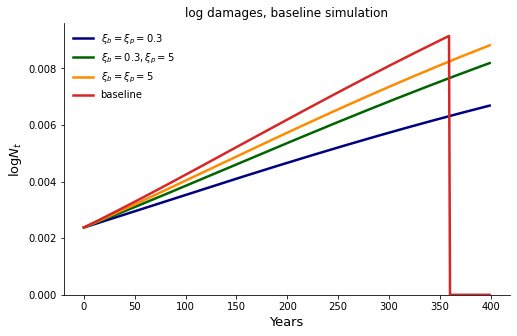

In [131]:
# log damage, baseline
fig = plt.figure(figsize=(8,5))
# plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_browian*γ1 + γ2/2*yt_browian**2) - np.log(et_brownian) + np.log(η) - np.log(1 -η), label="brownian robust, jump robust", color="tab:blue")
# plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_smooth*γ1 + γ2/2*yt_smooth**2) - np.log(et_smooth) + np.log(η) - np.log(1 -η), label="smooth ambiguity, jump robust", color="darkgreen")


plt.plot( (yt_e1*γ1 + γ2/2*yt_e1**2), label="$ξ_b = ξ_p = 0.3$", color="navy")
plt.plot(  (yt_3*γ1 + γ2/2*yt_3**2) , label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot(  (yt_e2*γ1 + γ2/2*yt_e2**2) , label="$ξ_b = ξ_p = 5$", color="darkorange")
plt.plot(  (yt_bb*γ1 + γ2/2*yt_bb**2) , label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.ylim(0)
plt.title("log damages, baseline simulation")
plt.ylabel('$\log N_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/logn_baseline.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Years')

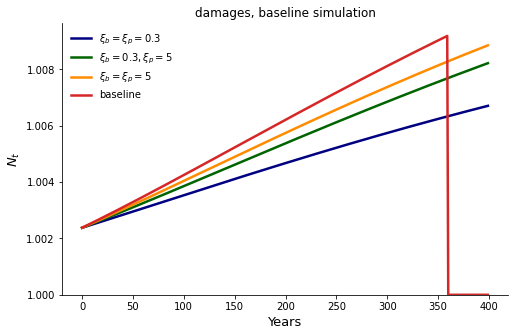

In [132]:
# damages,baseline simulation
fig = plt.figure(figsize=(8,5))
plt.plot(np.exp(yt_e1*γ1 + γ2/2*yt_e1**2), label="$ξ_b = ξ_p = 0.3$", color="navy")
plt.plot( np.exp(yt_3*γ1 + γ2/2*yt_3**2) , label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot(  np.exp(yt_e2*γ1 + γ2/2*yt_e2**2) , label="$ξ_b = ξ_p = 5$", color="darkorange")
plt.plot(  np.exp(yt_bb*γ1 + γ2/2*yt_bb**2) , label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.ylim(1)
plt.title("damages, baseline simulation")
plt.ylabel('$N_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/n_baseline.png",dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Years')

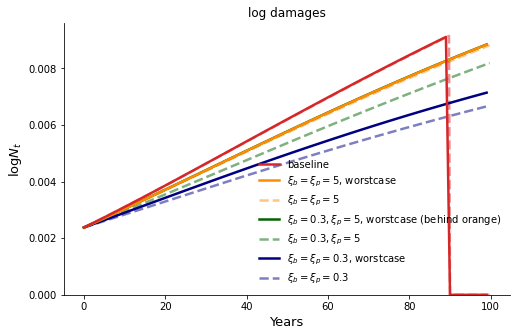

In [134]:
# log damages, worstcase
fig = plt.figure(figsize=(8,5))

plt.plot( years, (yt_e1*γ1 + γ2/2*yt_e1**2), label="$ξ_b = ξ_p = 0.3$", color="navy", alpha=0.5, linestyle="dashed")
plt.plot( years, (yt_3*γ1 + γ2/2*yt_3**2) , label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen", alpha=0.5, linestyle="dashed")
plt.plot( years,  (yt_e2*γ1 + γ2/2*yt_e2**2) , label="$ξ_b = ξ_p = 5$", color="darkorange", alpha=0.5, linestyle="dashed")
plt.plot( years, (yt_bb*γ1 + γ2/2*yt_bb**2) , label="baseline", color="tab:red", alpha=0.5, linestyle="dashed")

plt.plot( (yt_e1w*γ1 + γ2/2*yt_e1w**2), label="$ξ_b = ξ_p = 0.3$, worstcase", color="navy")
plt.plot(  (yt_3w*γ1 + γ2/2*yt_3w**2) , label="$ξ_b =0.3, ξ_p = 5$, worstcase (behind orange)", color="darkgreen")
plt.plot(  (yt_e2w*γ1 + γ2/2*yt_e2w**2) , label="$ξ_b = ξ_p = 5$, worstcase", color="darkorange")
plt.plot(  (yt_bbw*γ1 + γ2/2*yt_bbw**2) , label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [7,6,2, 5, 1, 4,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.ylim(0)
plt.title("log damages")
plt.ylabel('$\log N_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/logn.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Years')

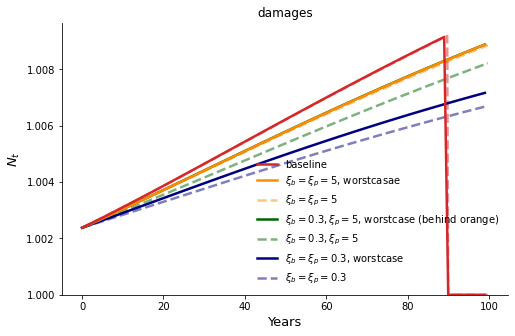

In [136]:
# damages, worstcase simulation
fig = plt.figure(figsize=(8,5))
plt.plot(years, np.exp(yt_e1*γ1 + γ2/2*yt_e1**2), label="$ξ_b = ξ_p = 0.3$", color="navy", alpha=0.5, linestyle="dashed")
plt.plot(years, np.exp(yt_3*γ1 + γ2/2*yt_3**2) , label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen", alpha=0.5, linestyle="dashed")
plt.plot(years,  np.exp(yt_e2*γ1 + γ2/2*yt_e2**2) , label="$ξ_b = ξ_p = 5$", color="darkorange", alpha=0.5, linestyle="dashed")
plt.plot(years,  np.exp(yt_bb*γ1 + γ2/2*yt_bb**2) , label="baseline", color="tab:red", alpha=0.5, linestyle="dashed")

plt.plot(np.exp(yt_e1w*γ1 + γ2/2*yt_e1w**2), label="$ξ_b = ξ_p = 0.3$, worstcase", color="navy")
plt.plot( np.exp(yt_3w*γ1 + γ2/2*yt_3w**2) , label="$ξ_b =0.3, ξ_p = 5$, worstcase (behind orange)", color="darkgreen")
plt.plot(  np.exp(yt_e2w*γ1 + γ2/2*yt_e2w**2) , label="$ξ_b = ξ_p = 5$, worstcasae", color="darkorange")
plt.plot(  np.exp(yt_bbw*γ1 + γ2/2*yt_bbw**2) , label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [7,6,2, 5, 1, 4,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.ylim(1)
plt.title("damages")
plt.ylabel('$N_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/n.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

<ipython-input-137-a1531639c577>:1: RuntimeWarning: divide by zero encountered in true_divide
  me = δ*η/et_bb


IndexError: boolean index did not match indexed array along dimension 0; dimension is 100 but corresponding boolean dimension is 400

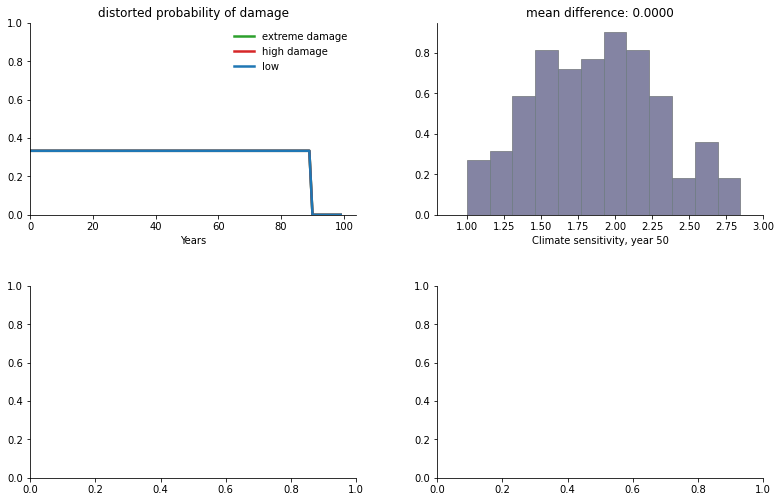

In [137]:
me = δ*η/et_bb
et_base = et_bb
fig, ((ax1, ax2), (ax3, ax4)) = plot_together(et,  θ_list, ht, πᶜt, πᵈt, me, dmg_weight)
fig.suptitle("$ξ_a = 1/100,\ ξ_w = 1/3.4,\ ξ_p =  5$")
# plt.savefig('15_600_1.pdf')
plt.show()